In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import time
import scipy.stats as ss
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate, Dropout
import warnings
warnings.filterwarnings("ignore")


DANE

PZU 2016-2024 #0-8 !!!!!!!!!!!!!!!!!!
ERGO HESTIA 2016-2024 #9-17 !!!!!!!!!!!!!!!zmiana
WARTA 2016-2024 #18-26 !!!!!!!!!!!!!!!!zmiana
AXA 2022-2024 #27-29 
ALIANZ FR 2016-2024 #30-38  !!!!!!!!!!!!!!!!!!!! zrobic od 17
ALIANZ IT 2017-2024 #39-46
ALIANZ UK 2021-2024 #47-50
ALIANZ ES 2017-2024 #51-58 zmiana
ALIANZ GE 2016-2024 #59-67  !!!!!!!!!!!!!!!!!!!!! zmiana
----PONIŻEJ TEGO INDEKY (-9)----
GROUPAMA 2016, 2018-2023 #78-84 zmiana
MUTUA MADRILENA 2019-2024 #85-90
MAPFRE VIDA 2020-2024 #91-95
MAPFRE ESPANA 2022-2024 #96-98 zrobic od 23 
MAPFRE RE 2020-2024 #99-103
MAPFRE ASISTENCIA 2020-2024 #104-108
VERTI 2020-2024 #109-113
HDI Assicurazioni 2016-2024 #114-122 !!!!!!!!!!!!!!!!! zmiana do 22 (złączenie firm) mozna pokazac miedzy 22 a 23 roznice
HDI Global SE 2016-2024 #123-131 !!!!!!!!!!!!!!!!!!! zmiana
HDI Global Specialty SE 2019-2022 2024 #132-136
HDI ITALIA S.p.A. 2021-2022 #137-138
HDI Versicherung AG 2016, 2018-2021, 2023-2024 #139-145 zmiana
HDI Versicherung AG (Austria) 2016-2024 #146-154 !!!!!!!!!!!!!!!!!!!! zmiana
LPV Versicherung AG 2016-2024 #155-163 !!!!!!!!!!!!!!!!!!!!!!! zmiana
neue leben Unfallversicherung AG 2020-2024 #164-168 zmiana
TARGO Versicherung AG 2016-2024 #169-177
MMA IARD SA 2018-2024 #178-184 zmiana
MAAF ASSURANCES SA 2018-2024 #185-191 zmiana
LA SAUVEGARDE 2018-2024 #192-198 zmiana
GMF ASSURANCES 2018-2024 #199-205 zmiana
----PONIŻEJ TEGO INDEKY (-16)----
BPCE IARD 2018-2024 #212-218 zmiana
PRTOEC BTP 2018-2019 #219-220
GENERALI 2018-2024 #221-228 różnica pomiędzy 21 a 22
 

In [2]:
with open('dane.txt', 'r') as file:
    DATA = [[int(liczba) for liczba in linia.strip().split(',')] for linia in file]
    data = []
    for i in range(len(DATA)):
        table = pd.DataFrame([
    [DATA[i][0], DATA[i][1], DATA[i][2], DATA[i][3], DATA[i][4], DATA[i][5], DATA[i][6], DATA[i][7], DATA[i][8], DATA[i][9]],
    [DATA[i][10], DATA[i][11], DATA[i][12], DATA[i][13], DATA[i][14], DATA[i][15], DATA[i][16], DATA[i][17], DATA[i][18], None],
    [DATA[i][19], DATA[i][20], DATA[i][21], DATA[i][22], DATA[i][23], DATA[i][24], DATA[i][25], DATA[i][26], None, None],
    [DATA[i][27], DATA[i][28], DATA[i][29], DATA[i][30], DATA[i][31], DATA[i][32], DATA[i][33], None, None, None],
    [DATA[i][34], DATA[i][35], DATA[i][36], DATA[i][37], DATA[i][38], DATA[i][39], None, None, None, None],
    [DATA[i][40], DATA[i][41], DATA[i][42], DATA[i][43], DATA[i][44], None, None, None, None, None],
    [DATA[i][45], DATA[i][46], DATA[i][47], DATA[i][48], None, None, None, None, None, None],
    [DATA[i][49], DATA[i][50], DATA[i][51], None, None, None, None, None, None, None],
    [DATA[i][52], DATA[i][53], None, None, None, None, None, None, None, None],
    [DATA[i][54], None, None, None, None, None, None, None, None, None]]
, index=[i for i in range(10)], columns = [i for i in range(10)])
        data.append(table)

In [3]:
def mack_chainladder(triangle, ifcum = False):
    data = triangle.copy()
    I = len(data)
    if ifcum == False:
        for i in range(I):
            for j in range(1, I):
                if pd.notna(data.iloc[i, j]):
                    data.iloc[i, j] += data.iloc[i, j - 1]
    factors = []
    for i in range(I - 1):
        factors.append(data.iloc[:, i+1].sum()/data.iloc[:-(i+1), i].sum())
    sigma_squared = []
    for i in range(I - 2):
        l = 0
        for j in range(9 - i):
            l += data.iloc[j, i] * ((data.iloc[j, i+1]/data.iloc[j, i]) - factors[i])**2
        sigma_squared.append(l/(9-i-1))
    if sigma_squared[-1] == 0:
        sigma_squared.append(0)
    else:
        sigma_squared.append(np.minimum(sigma_squared[-1]**2/sigma_squared[-2], np.minimum(sigma_squared[-1], sigma_squared[-2])))
    triangle_pred = data.copy()
    for i in range(I):
        for j in range(1, I):
            if pd.isna(triangle_pred.iloc[i, j]):
                triangle_pred.iloc[i, j] = triangle_pred.iloc[i, j-1] * factors[j-1]
    ibnr = triangle_pred.iloc[:, -1].sum() - np.trace(np.fliplr(triangle_pred.values))
    mse = 0
    for i in range(1, I):
        sum1 = 0
        for j in range(I - i - 1, I - 1):
            term1 = sigma_squared[j] / factors[j]**2 / triangle_pred.iloc[i, j]
            denom = sum(triangle_pred.iloc[k, j] for k in range(I - j - 1))
            term2 = sigma_squared[j] / factors[j]**2 / denom
            sum1 += term1 + term2
        part1 = triangle_pred.iloc[i, I-1]**2 * sum1
        sum2 = sum(triangle_pred.iloc[k, j] for k in range(i + 1, I))
        sum3 = 0
        for j in range(I - i - 1, I - 1):
            denom2 = sum(triangle_pred.iloc[n, j] for n in range(I - j - 1))
            sum3 += 2 * sigma_squared[j] / factors[j]**2 / denom2
        part2 = triangle_pred.iloc[i, I-1] * sum2 * sum3
        mse += part1 + part2
    interval = pd.DataFrame(np.nan, index = data.index, columns = data.columns)
    for i in range(I):
        for j in range(I):
            if pd.isna(data.iloc[i, j]):
                if i + j == I:
                    interval.iloc[i, j] = ss.norm.ppf(0.975) * np.sqrt(sigma_squared[j-1] * triangle_pred.iloc[i, j-1]) #sigma_squared[j-1] * triangle_pred.iloc[i, j-1] 
                else:
                    interval.iloc[i, j] = interval.iloc[i, j-1] + ss.norm.ppf(0.975) * np.sqrt(sigma_squared[j-1] * triangle_pred.iloc[i, j-1]) #interval.iloc[i, j-1] + sigma_squared[j-1] * triangle_pred.iloc[i, j-1]
    return [factors, sigma_squared, triangle_pred, ibnr, np.sqrt(mse), np.sqrt(mse)/ibnr, interval]

def kronecker_delta(h, i):
    return 1 if h == i else 0

def hertig(triangle, ifcum = False):
    data = triangle.copy()
    I = len(data)
    if ifcum == False:
        for i in range(I):
            for j in range(1, I):
                if pd.notna(data.iloc[i, j]):
                    data.iloc[i, j] += data.iloc[i, j - 1]
    factors = []
    for j in range(1, I):
        sum = 0
        for i in range(I - j):
            sum += np.log(data.iloc[i, j] / data.iloc[i, j-1])
        factors.append(sum/(I-j))
    sigma_squared = []
    for j in range(1, I-1):
        sum = 0
        for i in range(I - j):
            sum += (np.log(data.iloc[i, j] / data.iloc[i, j-1]) - factors[j-1])**2
        sigma_squared.append(sum/(I-j-1))
    sigma_squared.append(sigma_squared[-1])
    triangle_pred = data.copy()
    for i in range(I):
        for j in range(1, I):
            if pd.isna(triangle_pred.iloc[i, j]):
                sum = 0
                for m in range(I - i - 1, j):
                    correction = 0.5 * sigma_squared[m] * (1 + 1 / (I - m - 1))
                    sum += factors[m] + correction

                log_base = np.log(triangle_pred.iloc[i, I - i - 1])
                triangle_pred.iloc[i, j] = np.exp(log_base + sum)
    ibnr = triangle_pred.iloc[:, -1].sum() - np.trace(np.fliplr(triangle_pred.values))
    mse = 0
    for h in range(I):
        for i in range(h, I):
            inner_sum = 0
            for m in range(I - i - 1, I - 1):
                delta = kronecker_delta(h, i)
                inner_sum += sigma_squared[m] * (1 / (I - m - 1) + delta)
            exponent = np.exp(inner_sum) - 1
            mse += triangle_pred.iloc[h, I-1] * triangle_pred.iloc[i, I-1] * exponent
    interval = pd.DataFrame(np.nan, index = data.index, columns = data.columns)
    for i in range(I):
        for j in range(1, I):
            if pd.isna(data.iloc[i, j]):
                sum = 0
                for m in range(I - 1 - i, j):
                    sum += sigma_squared[m] * (1 + 1 / (I - m - 1))
                interval.iloc[i, j] = triangle_pred.iloc[i, j-1] * (np.exp(sum) - 1) #ss.norm.ppf(0.975) * np.sqrt(triangle_pred.iloc[i, j-1] * (np.exp(sum) - 1)) # triangle_pred.iloc[i, j-1] * (np.exp(sum) - 1)

    return [factors, sigma_squared, triangle_pred, ibnr, np.sqrt(mse), np.sqrt(mse)/ibnr, interval]

In [4]:
res_mack, res_hertig = [], []
for i in range(len(data)):
    res_mack.append(mack_chainladder(data[i], ifcum=False))
    res_hertig.append(hertig(data[i], ifcum=False))

In [5]:
def triangle_list_to_array(triangle_list, cum = True):
    triangles = [df.copy() for df in triangle_list] 
    num_models = len(triangle_list)
    max_rows = max(df.shape[0] for df in triangle_list)
    max_cols = max(df.shape[1] for df in triangle_list)

    result = np.full((num_models, max_rows, max_cols), np.nan)

    for model_idx, triangle in enumerate(triangles):
        for i in range(triangle.shape[0]):
            for j in range(triangle.shape[1]):
                if cum == True:
                    if j > 0:
                        if pd.notna(triangle.iloc[i, j]):
                            triangle.iloc[i, j] += triangle.iloc[i, j - 1]
                value = triangle.iloc[i, j]
                if pd.notna(value):
                    result[model_idx, i, j] = value

    return result

def return_ibnr_cum(data_):
    df = pd.DataFrame(data_)
    return df.iloc[:, -1].sum() - np.trace(np.fliplr(df.values))

def return_ibnr_non_cum(data_):
    df = pd.DataFrame(data_)
    sum1 = 0
    sum = 0
    for i in range(df.shape[0]):
        sum1 += df.iloc[i, :df.shape[0]-i].sum()
        sum += df.iloc[i, :].sum()
    return sum - sum1

In [6]:
def prepare_training_data_with_previous_values(triangles):
    data = []
    for t_id, triangle in enumerate(triangles):
        size = triangle.shape[0]
        for i in range(1, size):
            for j in range(1, size):
                if not np.isnan(triangle[i, j]):
                    prev_vals1 = np.mean(triangle[:i, j])
                    prev_vals2 = np.mean(triangle[:i, j-1])
                    previous_value = triangle[i, j-1]
                    data.append([t_id, i, j] + [prev_vals1, prev_vals2, previous_value] + [triangle[i, j]])
    return pd.DataFrame(data, columns=[
        "triangle_id", "origin", "dev"] + [f"prev_value_{i}" for i in range(1,4)] + ["value"]
    )

def model_prediction_gb(triangles, model):
    res = triangles.copy()
    for triangle in res:
        size = triangle.shape[0]
        for i in range(size):
            for j in range(size):
                if pd.isna(triangle[i, j]):
                    prediction = model.predict([[i, j, np.mean(triangle[:i, j]), np.mean(triangle[:i, j-1]), triangle[i, j-1]]])
                    triangle[i, j] = prediction
    return res

In [7]:
triangles = triangle_list_to_array(data, cum = False)
df = prepare_training_data_with_previous_values(triangles)
X, Y = df[["origin", "dev"] + [f"prev_value_{i}" for i in range(1, 4)]], df["value"]
X_temp, X_test, y_temp, y_test = train_test_split(X, Y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25)

In [8]:
n_estimators_list = [100, 250, 500]
learning_rate_list = [0.01, 0.05, 0.1, 0.2]
max_depth_list = [5, 6, 7]
times1_gbr, rmse_gbr, rmse_val_gbr, r2_gbr, r2_val_gbr = [], [], [], [], []
for n_estimators in n_estimators_list:
    for learning_rate in learning_rate_list:
        for max_depth in max_depth_list:
            start_time = time.time()
            model = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)
            model.fit(X_train, y_train)
            end_time = time.time()
            times1_gbr.append(round(end_time - start_time, 4))

            y_pred = model.predict(X_test)
            rmse_gbr.append(round(np.sqrt(mean_squared_error(y_test, y_pred))))
            r2_gbr.append(round(r2_score(y_test, y_pred), 4))

            y_val_pred = model.predict(X_val)
            rmse_val_gbr.append(round(np.sqrt(mean_squared_error(y_val, y_val_pred))))
            r2_val_gbr.append(round(r2_score(y_val, y_val_pred), 4))

In [9]:
triangles_ = triangle_list_to_array(data)
df_ = prepare_training_data_with_previous_values(triangles_)
X_, Y_ = df_[["origin", "dev"] + [f"prev_value_{i}" for i in range(1, 4)]], df_["value"]
X_temp_, X_test_, y_temp_, y_test_ = train_test_split(X_, Y_, test_size=0.2)
X_train_, X_val_, y_train_, y_val_ = train_test_split(X_temp_, y_temp_, test_size=0.25)

In [10]:
times1_gbr_, rmse_gbr_, rmse_val_gbr_, r2_gbr_, r2_val_gbr_ = [], [], [], [], []
for n_estimators in n_estimators_list:
    for learning_rate in learning_rate_list:
        for max_depth in max_depth_list:
            start_time = time.time()
            model_ = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)
            model_.fit(X_train_, y_train_)
            end_time = time.time()
            times1_gbr_.append(round(end_time - start_time, 4))

            y_pred_ = model_.predict(X_test_)
            rmse_gbr_.append(round(np.sqrt(mean_squared_error(y_test_, y_pred_))))
            r2_gbr_.append(round(r2_score(y_test_, y_pred_), 4))

            y_val_pred_ = model_.predict(X_val_)
            rmse_val_gbr_.append(round(np.sqrt(mean_squared_error(y_val_, y_val_pred_))))
            r2_val_gbr_.append(round(r2_score(y_val_, y_val_pred_), 4))
            # importances = model_.feature_importances_
            # feature_names = X_train.columns.tolist()
            # indices = np.argsort(importances)[::-1]
            # plt.figure(figsize=(10, 6))
            # plt.title("Feature Importances")
            # plt.bar(range(len(importances)), importances[indices], align="center")
            # plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
            # plt.xlabel("Features")
            # plt.ylabel("Importance")

In [11]:
table_gbr = pd.DataFrame({
    "n_estimators": [estimator for estimator in n_estimators_list for _ in range(len(learning_rate_list) * len(max_depth_list))],
    "learning_rate": [lr for _ in range(len(max_depth_list)) for lr in learning_rate_list for _ in range(len(n_estimators_list))],
    "max_depth": max_depth_list * len(learning_rate_list) * len(max_depth_list),
    "RMSE": rmse_gbr,
    "R^2": r2_gbr,
    "RMSE_val": rmse_val_gbr,
    "R^2_val": r2_val_gbr,
    "Time": times1_gbr
}) 
table_gbr_ = pd.DataFrame({
    "n_estimators": [estimator for estimator in n_estimators_list for _ in range(len(learning_rate_list) * len(max_depth_list))],
    "learning_rate": [lr for _ in range(len(max_depth_list)) for lr in learning_rate_list for _ in range(len(n_estimators_list))],
    "max_depth": max_depth_list * len(learning_rate_list) * len(max_depth_list),
    "RMSE": rmse_gbr_,
    "R^2": r2_gbr_,
    "RMSE_val": rmse_val_gbr_,
    "R^2_val": r2_val_gbr_,
    "Time": times1_gbr_
})

In [12]:
print(table_gbr.to_latex(index=False,
                  column_format = '|c|c|c|c|c|c|c|c|',
                  float_format=lambda x: ('%g' % x)))

\begin{tabular}{|c|c|c|c|c|c|c|c|}
\toprule
n_estimators & learning_rate & max_depth & RMSE & R^2 & RMSE_val & R^2_val & Time \\
\midrule
100 & 0.01 & 5 & 89722 & 0.8286 & 108580 & 0.7952 & 0.3432 \\
100 & 0.01 & 6 & 88984 & 0.8314 & 107852 & 0.7979 & 0.085 \\
100 & 0.01 & 7 & 89926 & 0.8278 & 108065 & 0.7971 & 0.115 \\
100 & 0.05 & 5 & 35568 & 0.9731 & 50653 & 0.9554 & 0.0681 \\
100 & 0.05 & 6 & 35060 & 0.9738 & 46427 & 0.9626 & 0.0842 \\
100 & 0.05 & 7 & 36247 & 0.972 & 46440 & 0.9625 & 0.1076 \\
100 & 0.1 & 5 & 33616 & 0.9759 & 46111 & 0.9631 & 0.065 \\
100 & 0.1 & 6 & 33248 & 0.9765 & 44965 & 0.9649 & 0.084 \\
100 & 0.1 & 7 & 36001 & 0.9724 & 44902 & 0.965 & 0.111 \\
100 & 0.2 & 5 & 33177 & 0.9766 & 43310 & 0.9674 & 0.14 \\
100 & 0.2 & 6 & 34896 & 0.9741 & 45733 & 0.9637 & 0.083 \\
100 & 0.2 & 7 & 35209 & 0.9736 & 45185 & 0.9645 & 0.133 \\
250 & 0.01 & 5 & 42007 & 0.9624 & 60766 & 0.9359 & 0.165 \\
250 & 0.01 & 6 & 40723 & 0.9647 & 57448 & 0.9427 & 0.2081 \\
250 & 0.01 & 7 & 41494 

In [13]:
print(table_gbr_.to_latex(index=False,
                  column_format = '|c|c|c|c|c|c|c|c|',
                  float_format=lambda x: ('%g' % x)))

\begin{tabular}{|c|c|c|c|c|c|c|c|}
\toprule
n_estimators & learning_rate & max_depth & RMSE & R^2 & RMSE_val & R^2_val & Time \\
\midrule
100 & 0.01 & 5 & 470142 & 0.8538 & 495669 & 0.8516 & 0.082 \\
100 & 0.01 & 6 & 468744 & 0.8547 & 493935 & 0.8527 & 0.089 \\
100 & 0.01 & 7 & 467975 & 0.8552 & 492728 & 0.8534 & 0.102 \\
100 & 0.05 & 5 & 71788 & 0.9966 & 69016 & 0.9971 & 0.072 \\
100 & 0.05 & 6 & 61619 & 0.9975 & 60832 & 0.9978 & 0.088 \\
100 & 0.05 & 7 & 57834 & 0.9978 & 58550 & 0.9979 & 0.122 \\
100 & 0.1 & 5 & 62779 & 0.9974 & 60221 & 0.9978 & 0.07 \\
100 & 0.1 & 6 & 55147 & 0.998 & 56631 & 0.9981 & 0.089 \\
100 & 0.1 & 7 & 51176 & 0.9983 & 54726 & 0.9982 & 0.118 \\
100 & 0.2 & 5 & 54854 & 0.998 & 56432 & 0.9981 & 0.069 \\
100 & 0.2 & 6 & 50361 & 0.9983 & 52504 & 0.9983 & 0.091 \\
100 & 0.2 & 7 & 50932 & 0.9983 & 51499 & 0.9984 & 0.132 \\
250 & 0.01 & 5 & 138476 & 0.9873 & 145009 & 0.9873 & 0.176 \\
250 & 0.01 & 6 & 132933 & 0.9883 & 137849 & 0.9885 & 0.21 \\
250 & 0.01 & 7 & 12986

In [14]:
def hide_values_for_backtest(triangles, start_from=3):
    masked_triangles = []
    for triangle in triangles:
        t = triangle.copy()
        size = t.shape[0]
        for i in range(start_from, size):
            for j in range(start_from, size):
                if i + j < size:
                    t[i, j] = np.nan
        masked_triangles.append(t)
    return np.array(masked_triangles)

In [15]:
def model_prediction_dl(triangles, model):
    res = triangles.copy()
    for triangle in res:
        size = triangle.shape[0]
        for i in range(1, size):
            for j in range(1, size):
                if np.isnan(triangle[i, j]):
                    seq_1 = triangle[:i, j-1]
                    seq_2 = triangle[:i, j]
                    val_prev = triangle[i, j-1]
                    max_len = max(len(seq_1), len(seq_2), 8)
                    seq_1 = np.pad(seq_1, (max_len - len(seq_1), 0), 'constant')
                    seq_2 = np.pad(seq_2, (max_len - len(seq_2), 0), 'constant')
                    seq = np.stack([seq_1, seq_2], axis=1)
                    seq = seq.reshape(1, seq.shape[0], seq.shape[1])
                    val = np.array([val_prev])
                    seq_fixed = seq.astype('float32')
                    val_fixed = val.flatten()
                    input_data = [seq_fixed, val_fixed]
                    prediction = model.predict(input_data)
                    triangle[i, j] = prediction[0][0]
    return res

def generate_sequences_all_triangles(triangles):
    X_all, y_all = [], []
    for triangle in triangles:
        size = triangle.shape[0]
        for i in range(1, size):
            for j in range(1, size):
                if np.isnan(triangle[i, j]) or np.isnan(triangle[i, j-1]):
                    continue
                seq_1 = triangle[:i, j-1]
                seq_2 = triangle[:i, j]
                val_prev = triangle[i, j-1]
                if np.isnan(seq_1).any() or np.isnan(seq_2).any():
                    continue
                max_len = max(len(seq_1), len(seq_2))
                seq_1 = np.pad(seq_1, (max_len - len(seq_1), 0), 'constant')
                seq_2 = np.pad(seq_2, (max_len - len(seq_2), 0), 'constant')
                full_seq = np.stack([seq_1, seq_2], axis=1)
                X_all.append((full_seq, val_prev))
                y_all.append(triangle[i, j])

    return X_all, y_all

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [16]:
with open('dane.txt', 'r') as file:
    DATA = [[int(liczba) for liczba in linia.strip().split(',')] for linia in file]
    data = []
    for i in range(len(DATA)):
        table = pd.DataFrame([
    [DATA[i][0], DATA[i][1], DATA[i][2], DATA[i][3], DATA[i][4], DATA[i][5], DATA[i][6], DATA[i][7], DATA[i][8], DATA[i][9]],
    [DATA[i][10], DATA[i][11], DATA[i][12], DATA[i][13], DATA[i][14], DATA[i][15], DATA[i][16], DATA[i][17], DATA[i][18], None],
    [DATA[i][19], DATA[i][20], DATA[i][21], DATA[i][22], DATA[i][23], DATA[i][24], DATA[i][25], DATA[i][26], None, None],
    [DATA[i][27], DATA[i][28], DATA[i][29], DATA[i][30], DATA[i][31], DATA[i][32], DATA[i][33], None, None, None],
    [DATA[i][34], DATA[i][35], DATA[i][36], DATA[i][37], DATA[i][38], DATA[i][39], None, None, None, None],
    [DATA[i][40], DATA[i][41], DATA[i][42], DATA[i][43], DATA[i][44], None, None, None, None, None],
    [DATA[i][45], DATA[i][46], DATA[i][47], DATA[i][48], None, None, None, None, None, None],
    [DATA[i][49], DATA[i][50], DATA[i][51], None, None, None, None, None, None, None],
    [DATA[i][52], DATA[i][53], None, None, None, None, None, None, None, None],
    [DATA[i][54], None, None, None, None, None, None, None, None, None]]
, index=[i for i in range(10)], columns = [i for i in range(10)])
        data.append(table)

In [17]:
X_combined, y = generate_sequences_all_triangles(triangles)

X_seq_raw = [x[0] for x in X_combined]
X_prev = np.array([x[1] for x in X_combined])
y = np.array(y)

X_seq_padded = pad_sequences(X_seq_raw, padding='pre', dtype='float32')

X_seq_temp, X_seq_test, X_prev_temp, X_prev_test, y_temp_dl, y_test_dl = train_test_split(X_seq_padded, X_prev, y, test_size = 0.2)
X_seq_train, X_seq_val, X_prev_train, X_prev_val, y_train_dl, y_val_dl = train_test_split(X_seq_temp, X_prev_temp, y_temp_dl, test_size = 0.25)
seq_input = Input(shape=(X_seq_train.shape[1], X_seq_train.shape[2]))
prev_input = Input(shape=(1,))

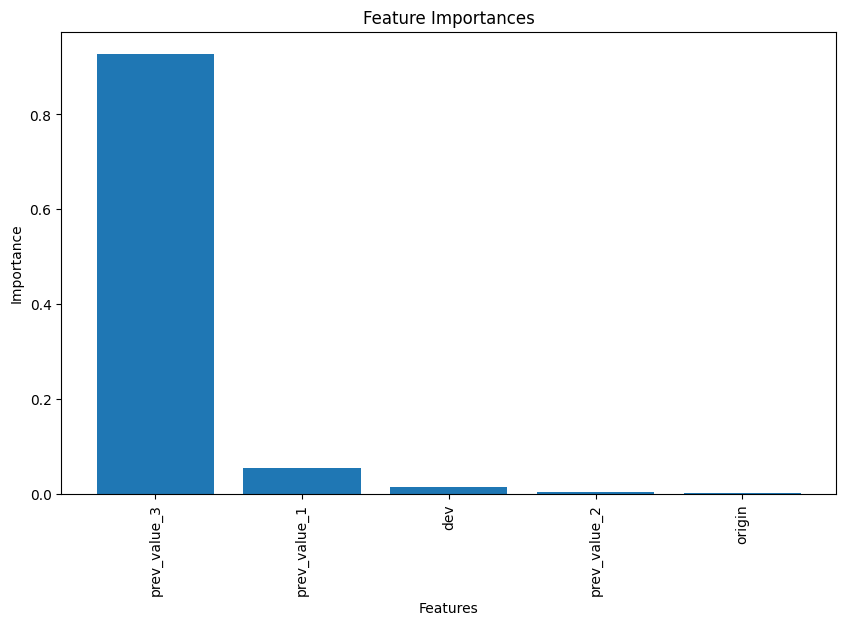

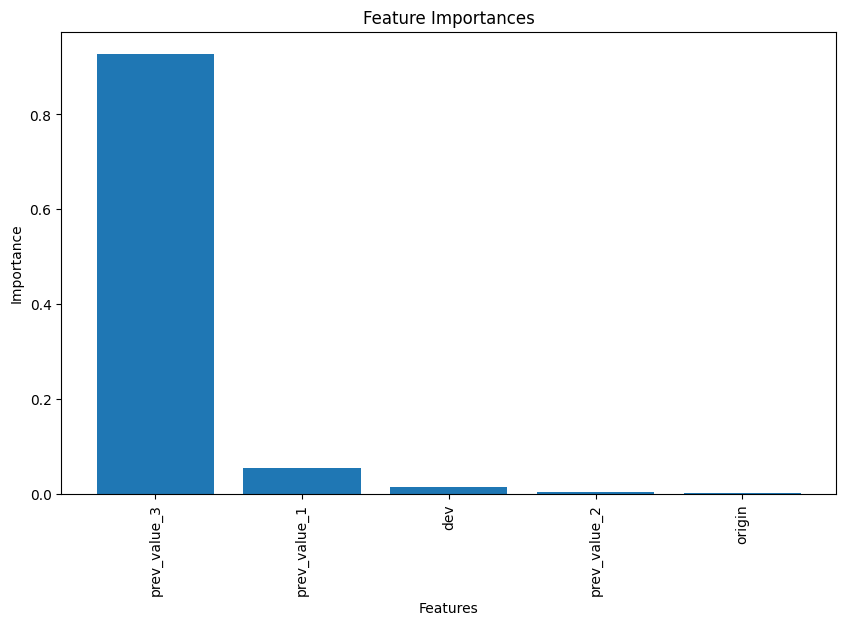

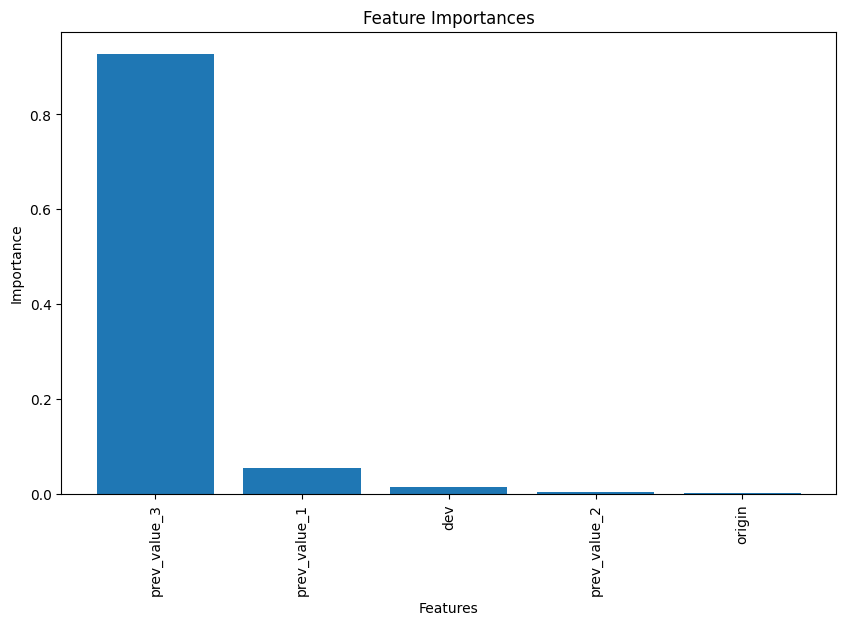

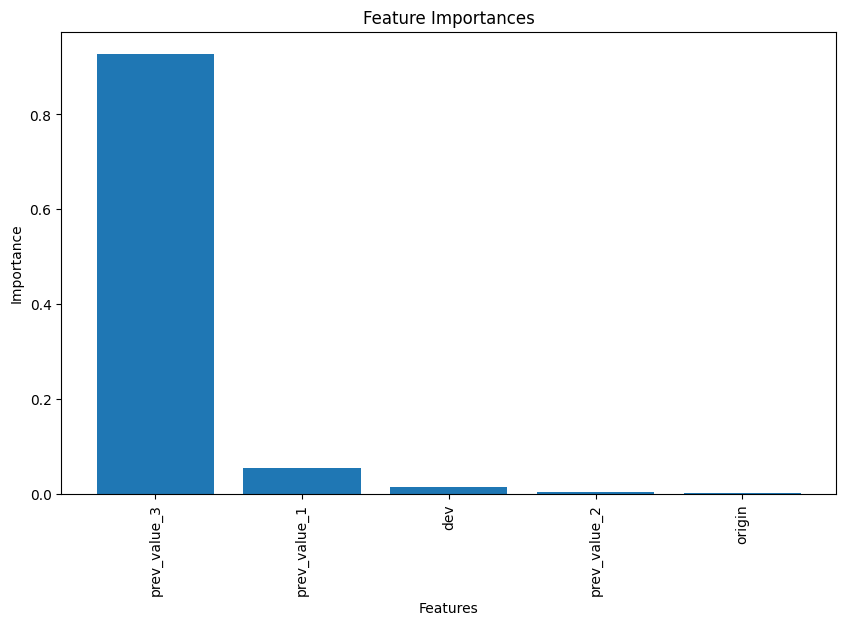

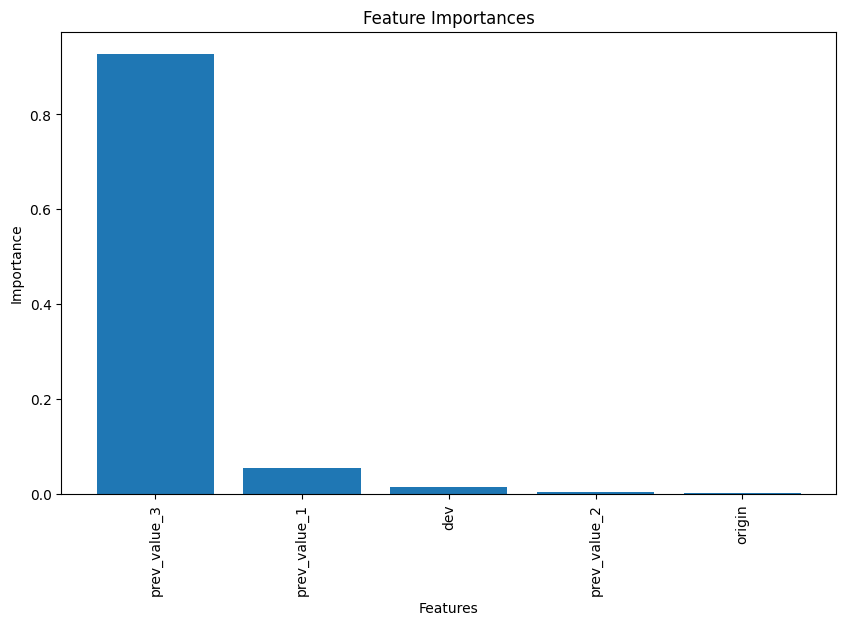

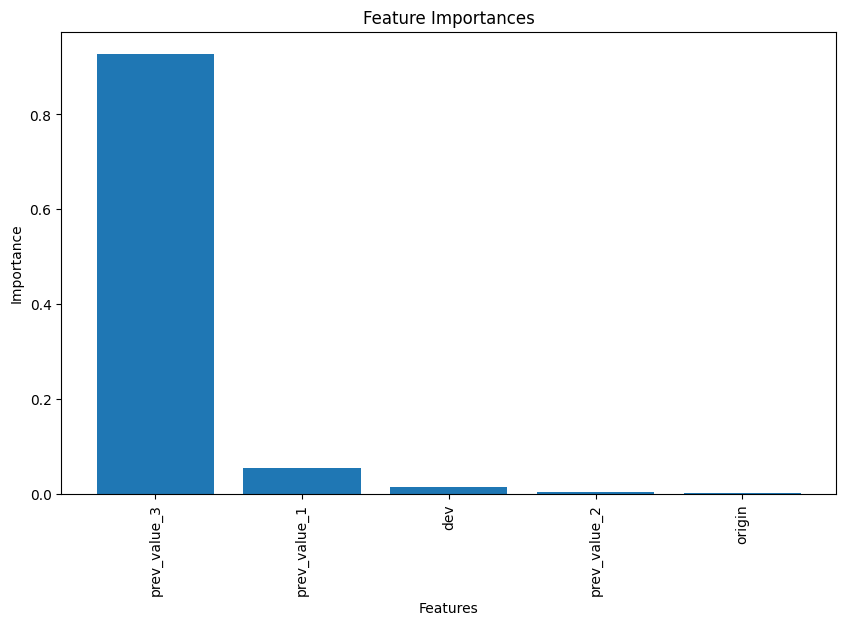

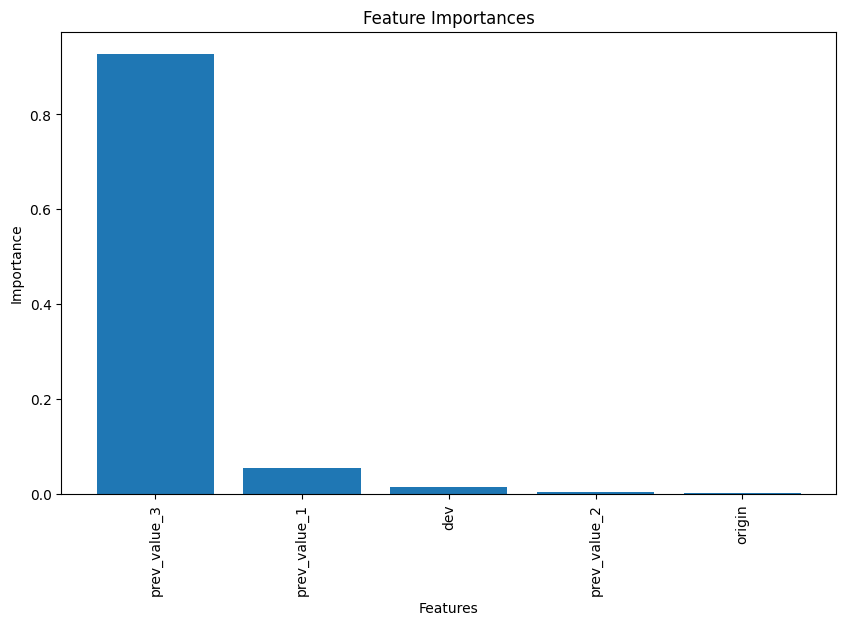

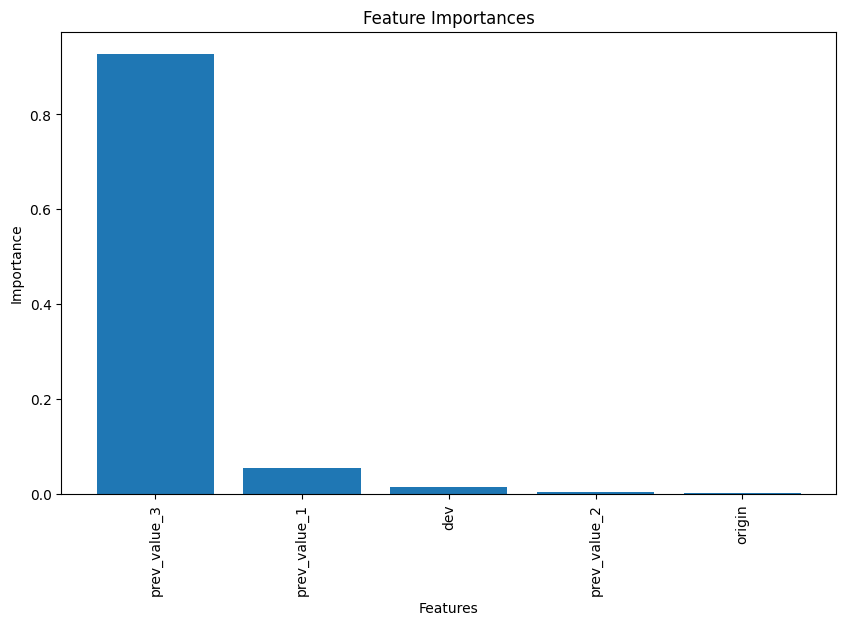

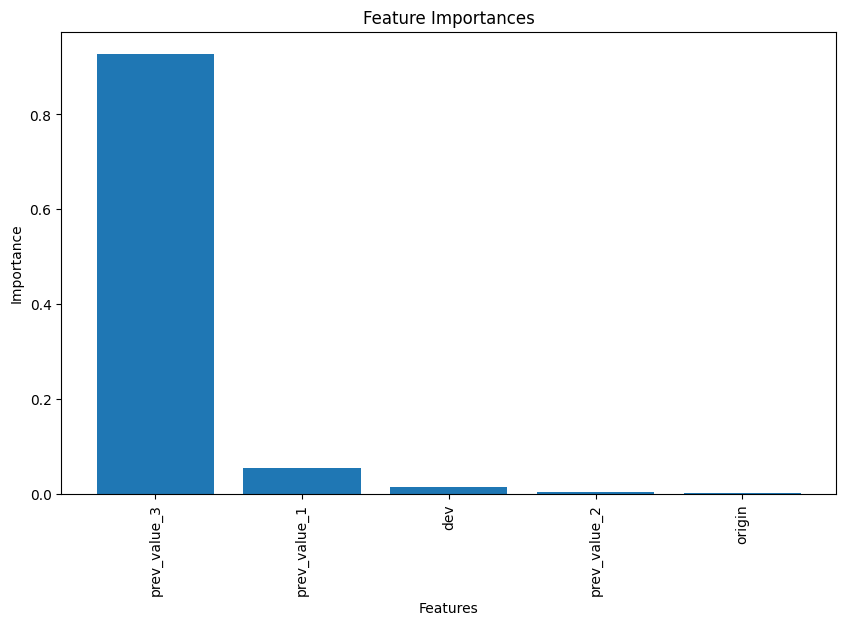

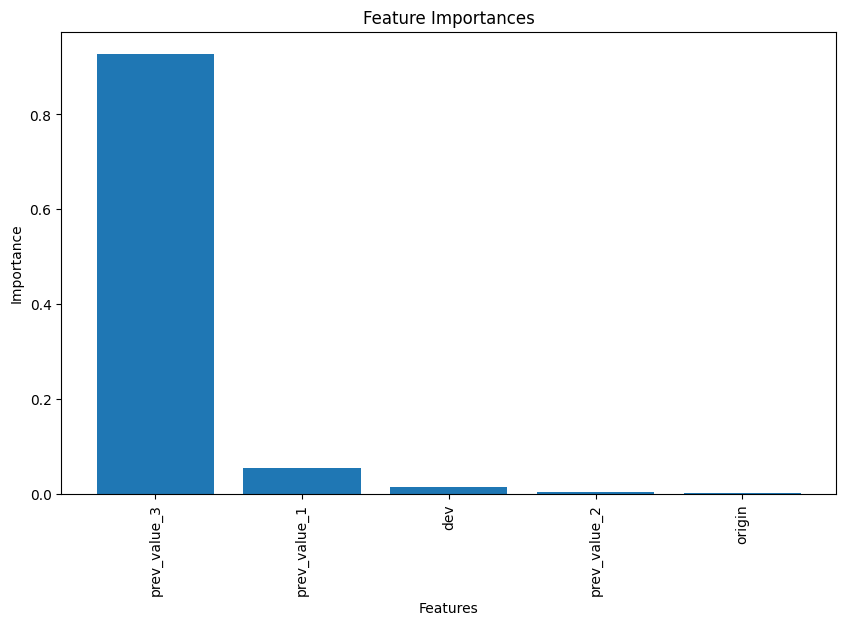

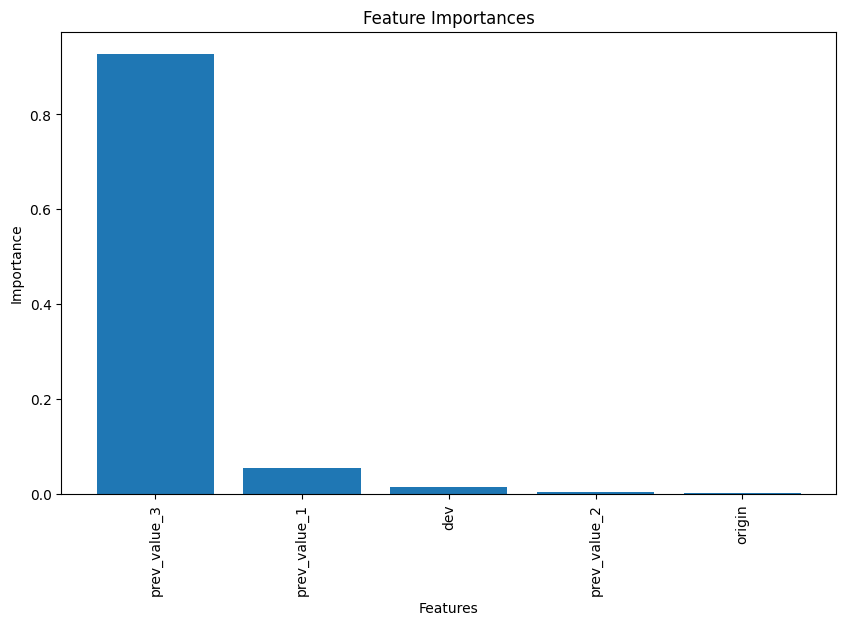

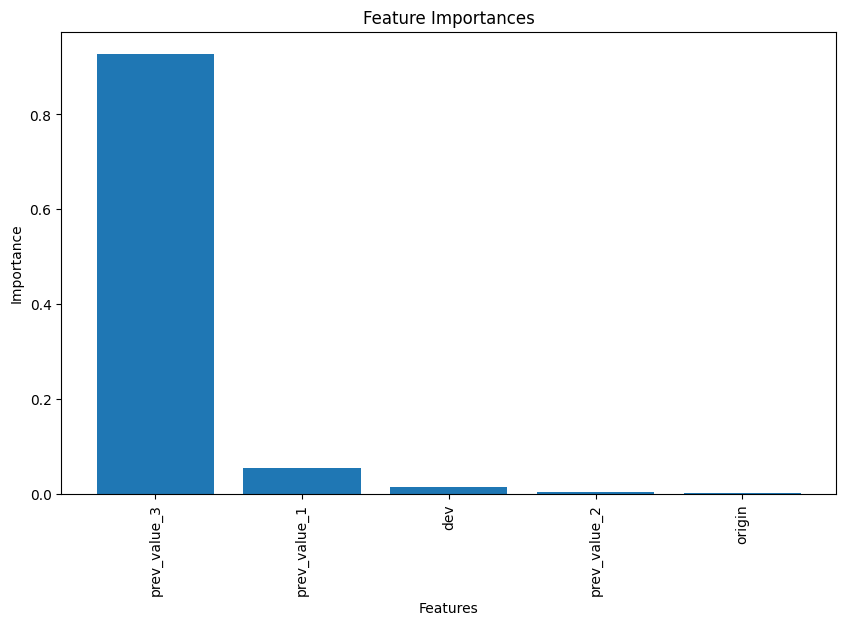

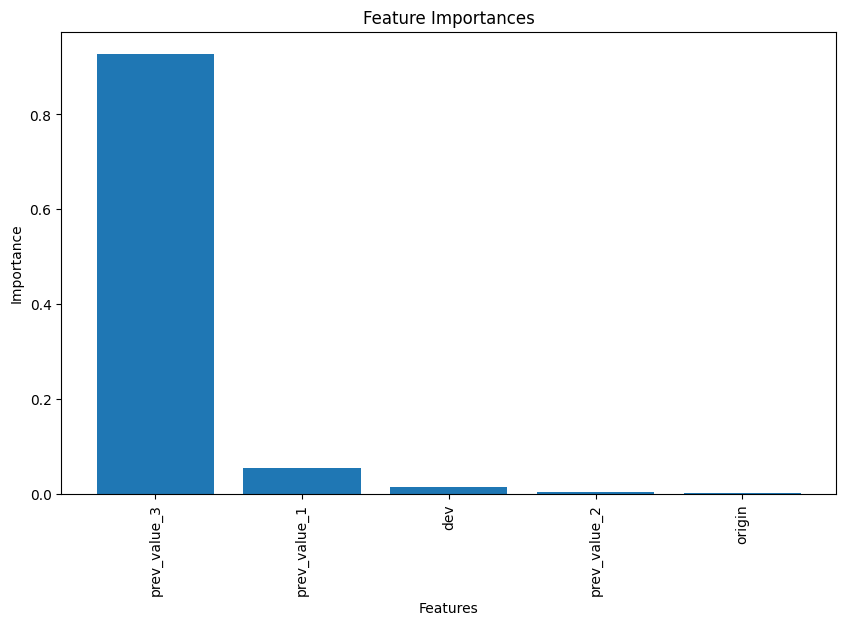

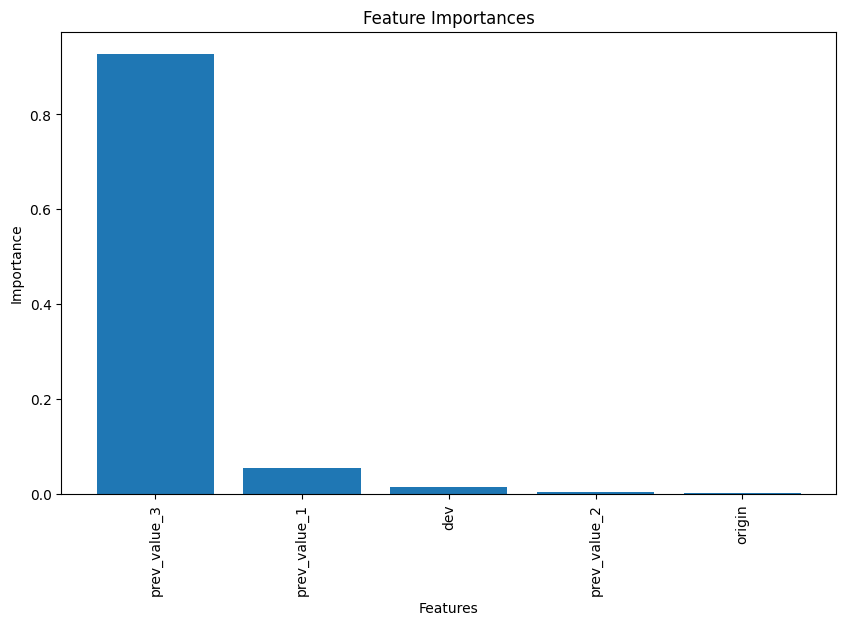

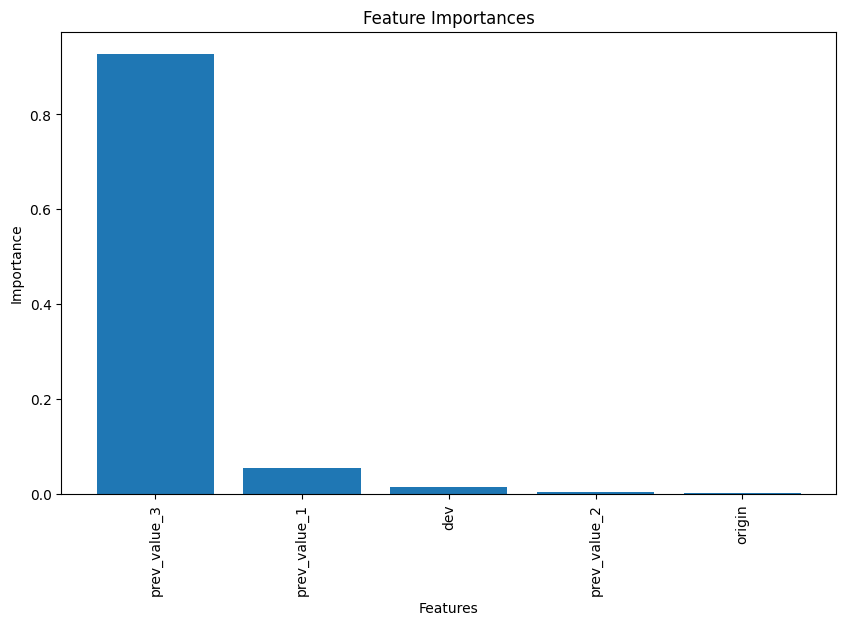

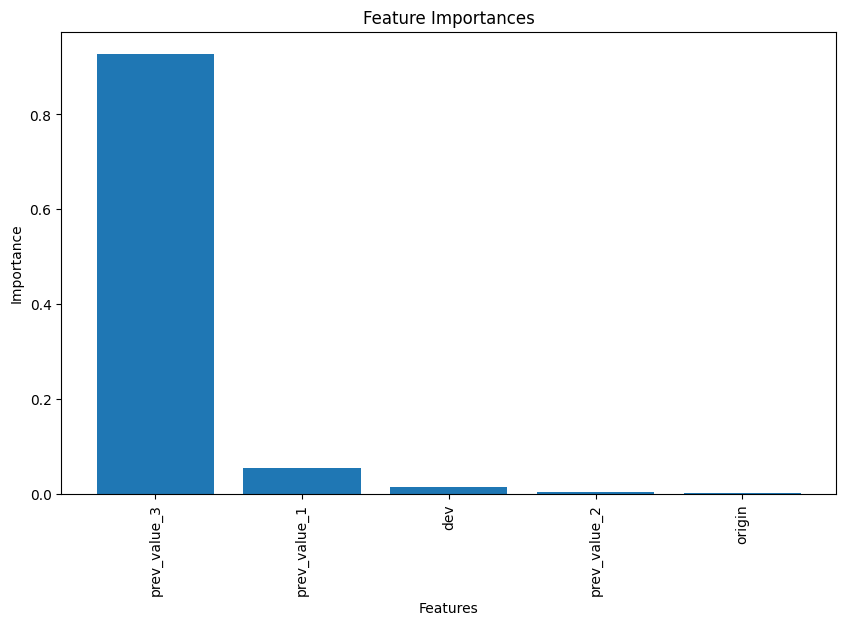

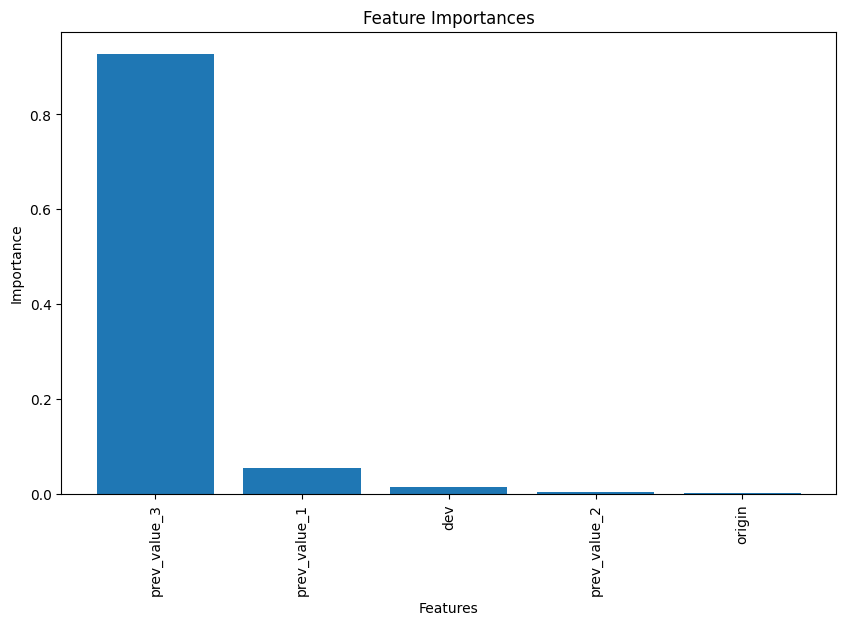

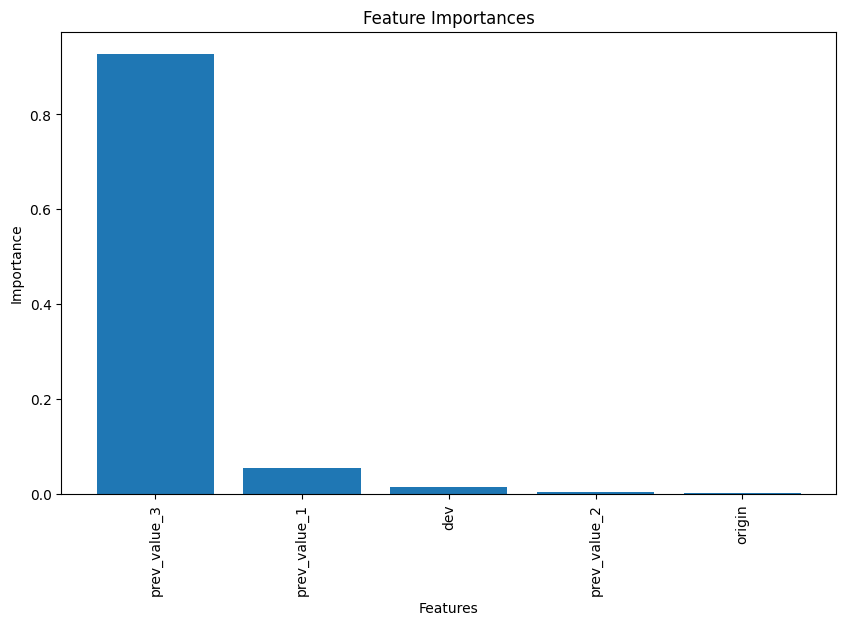

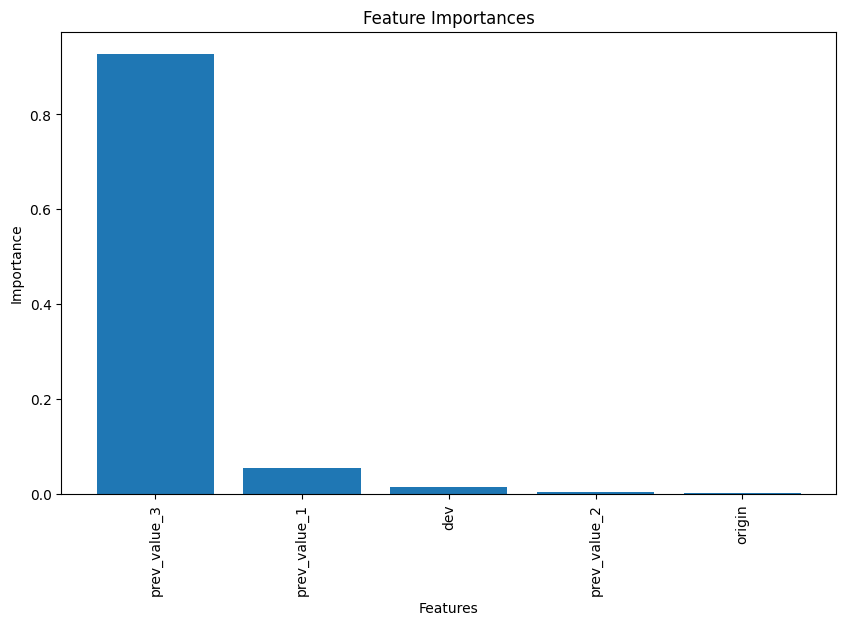

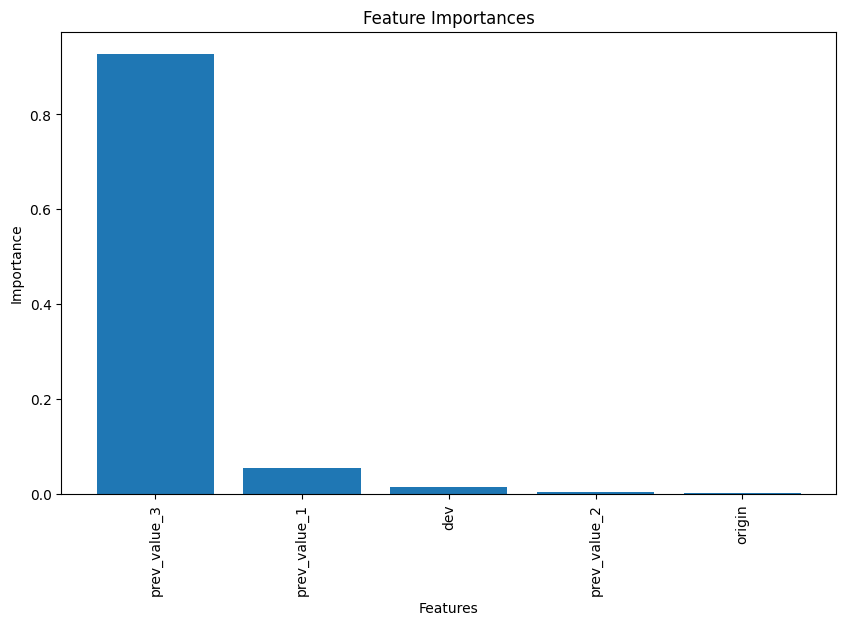

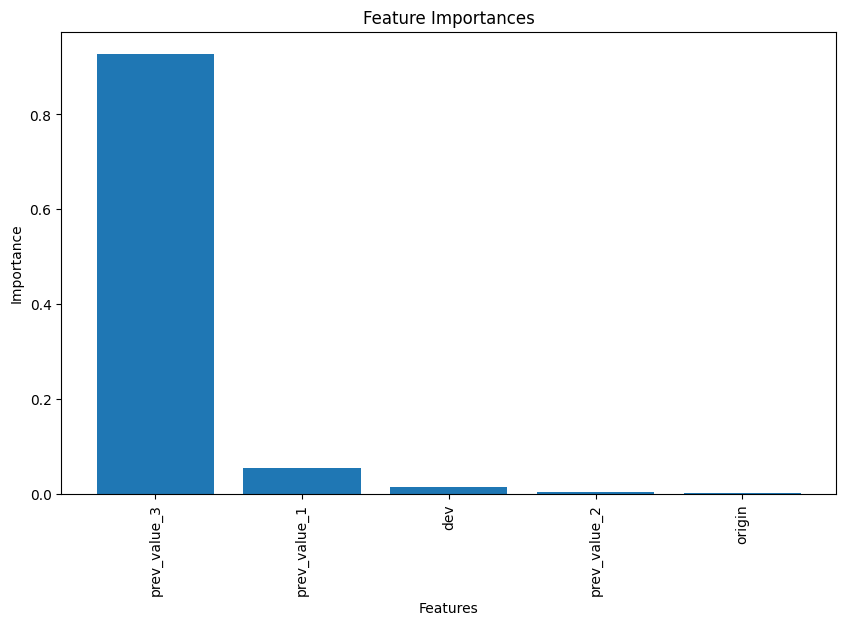

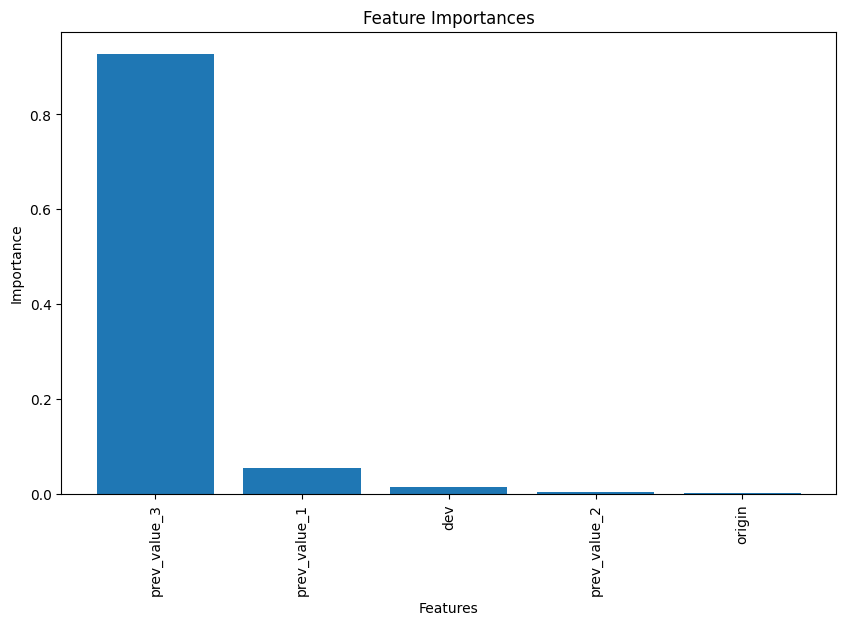

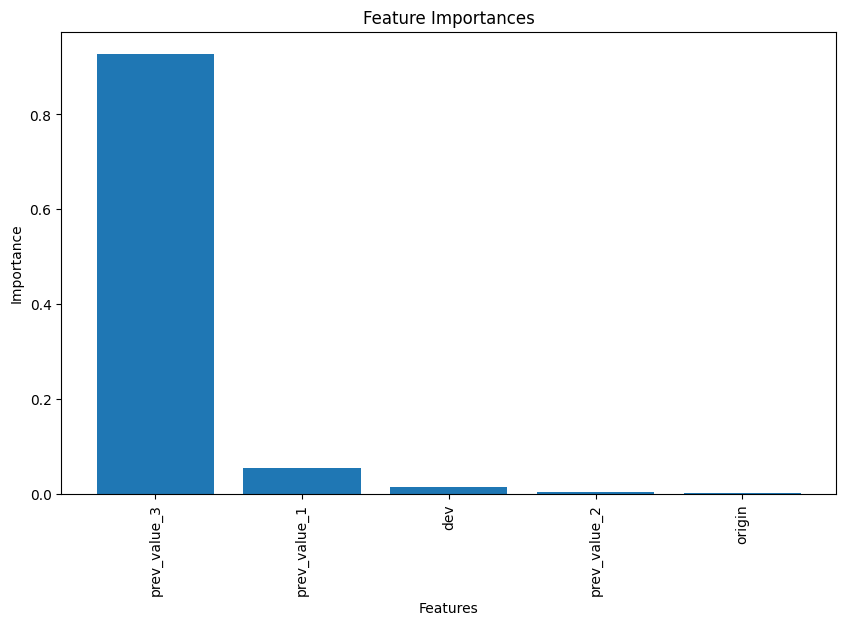

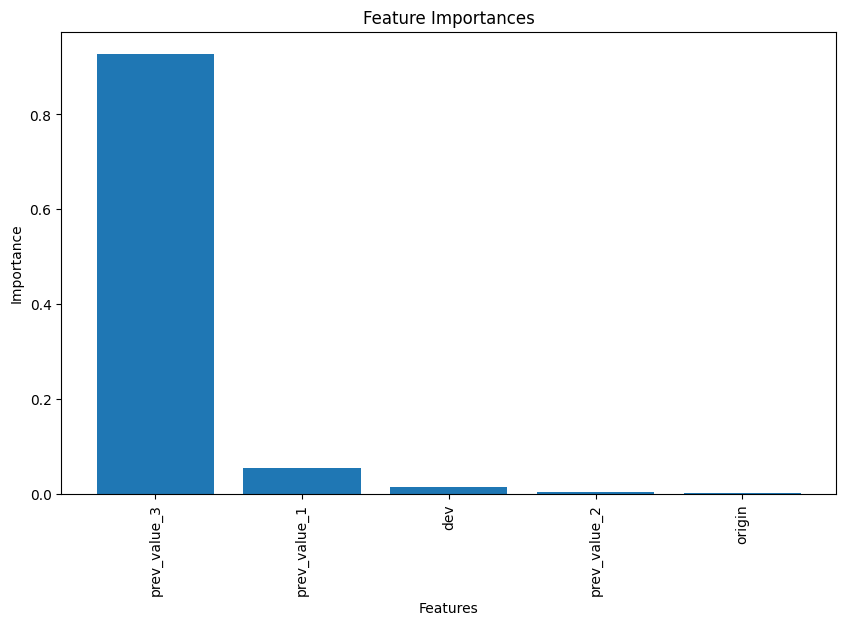

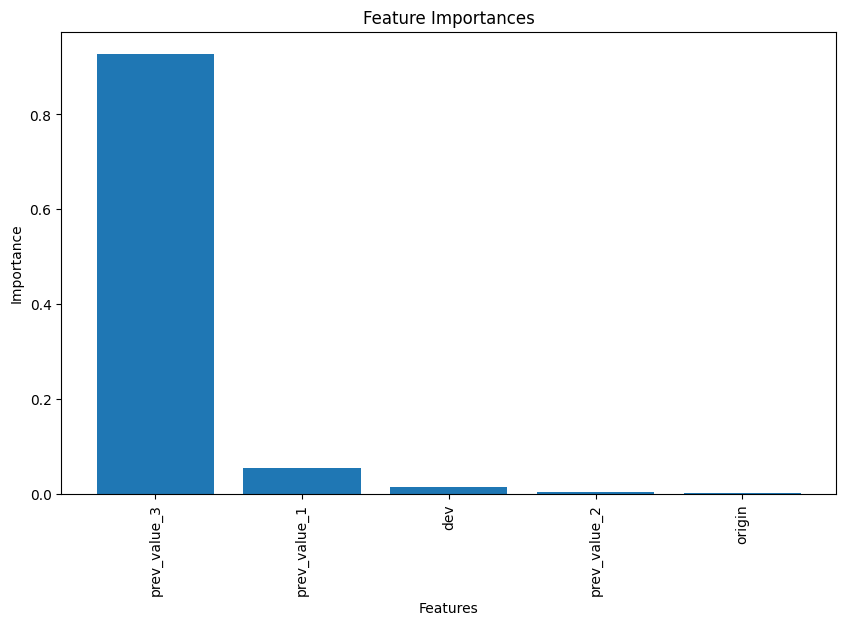

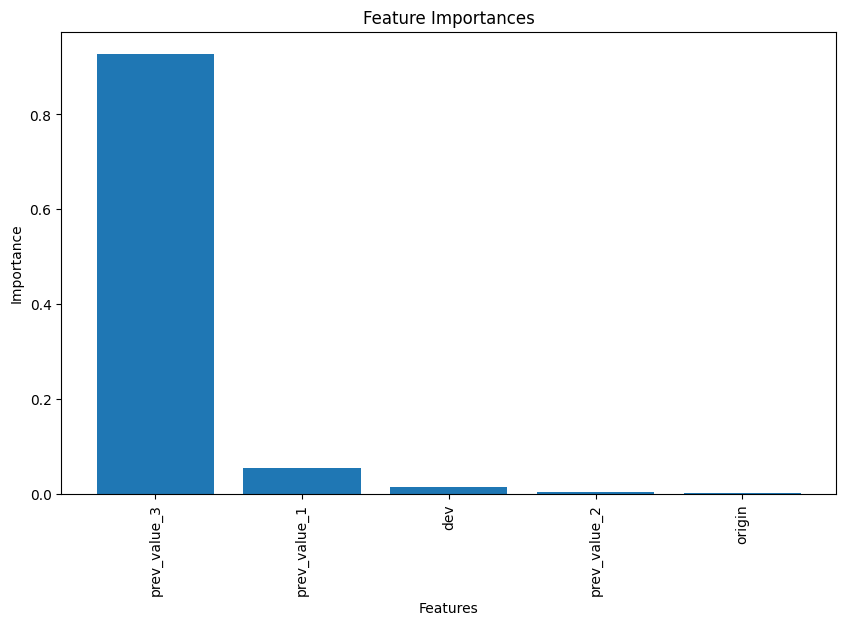

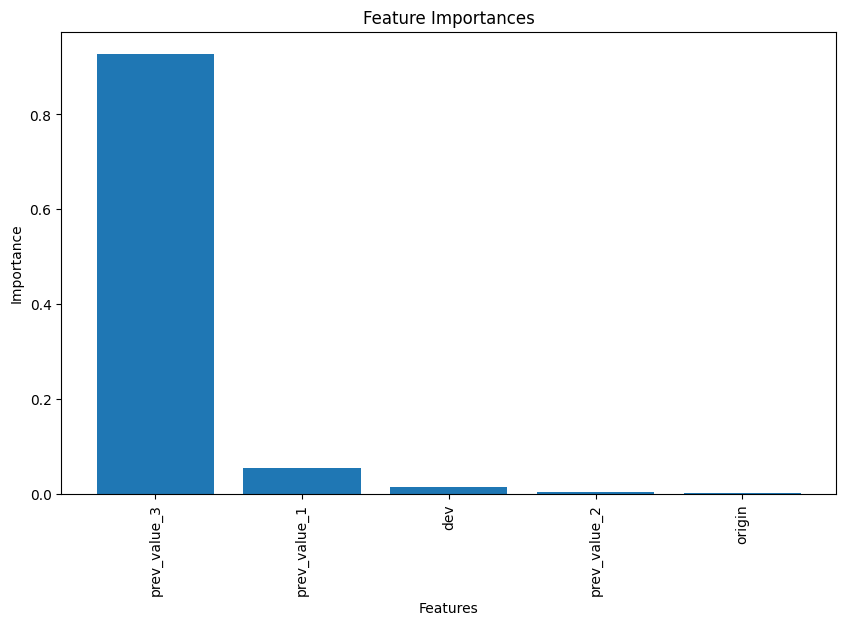

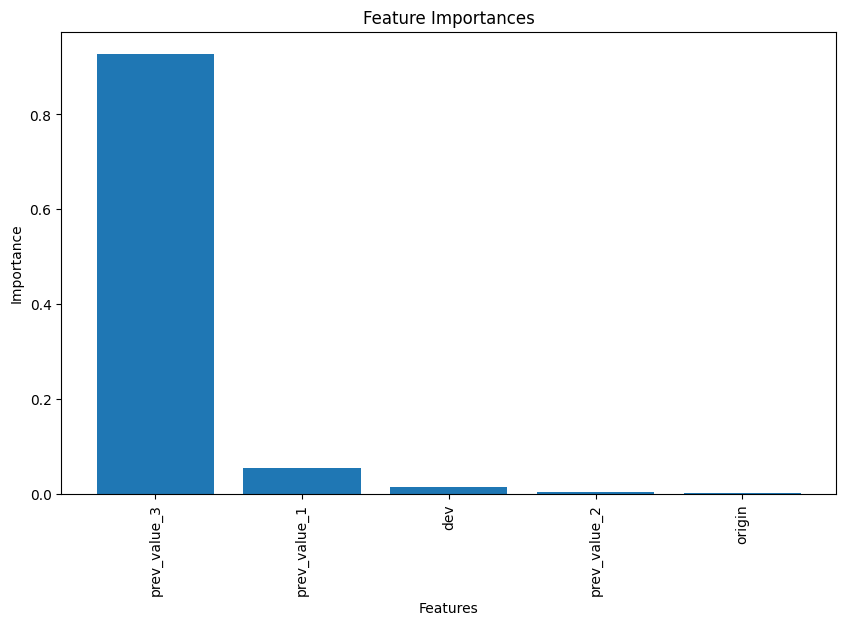

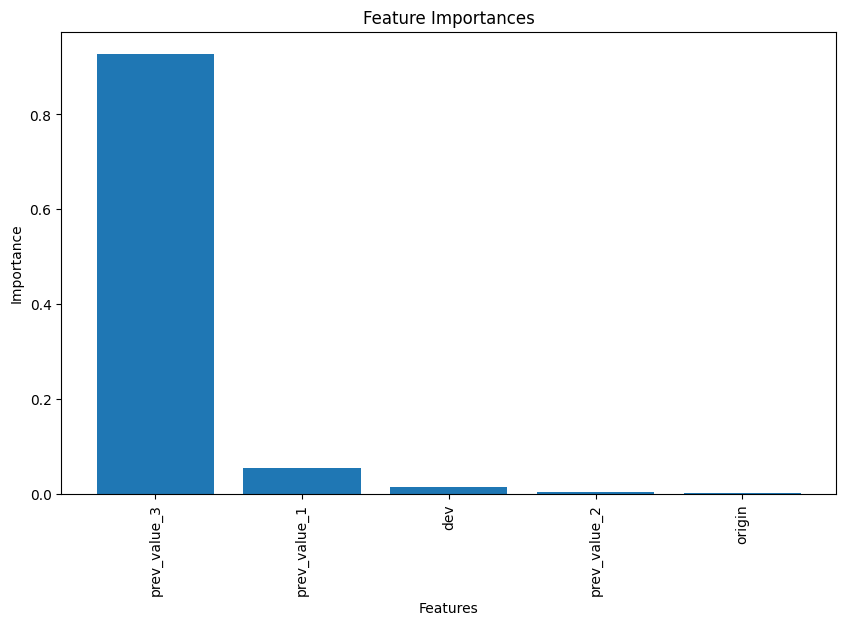

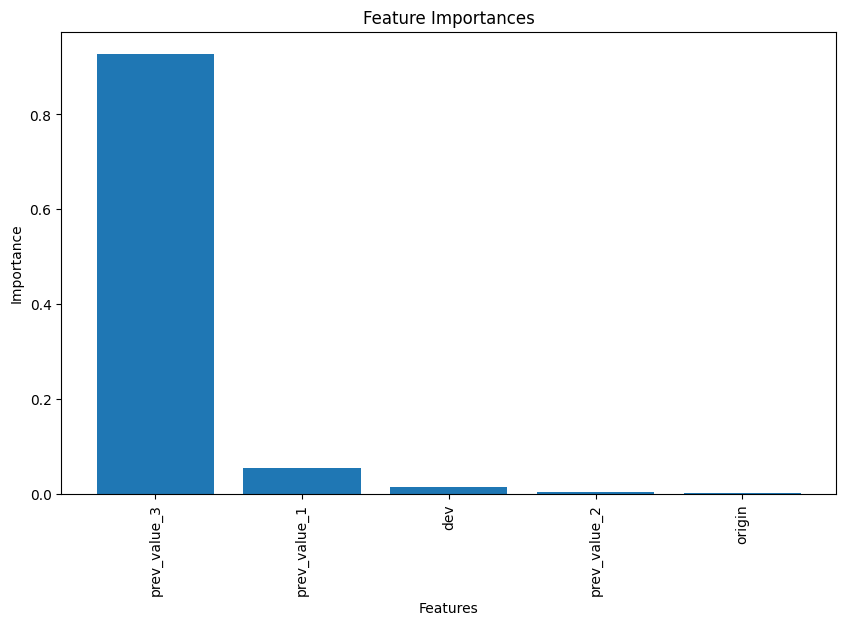

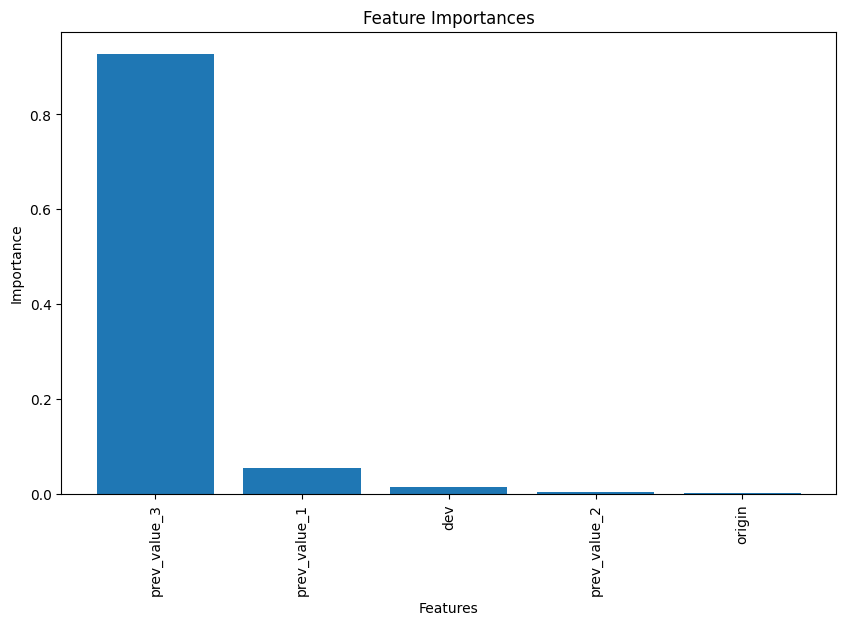

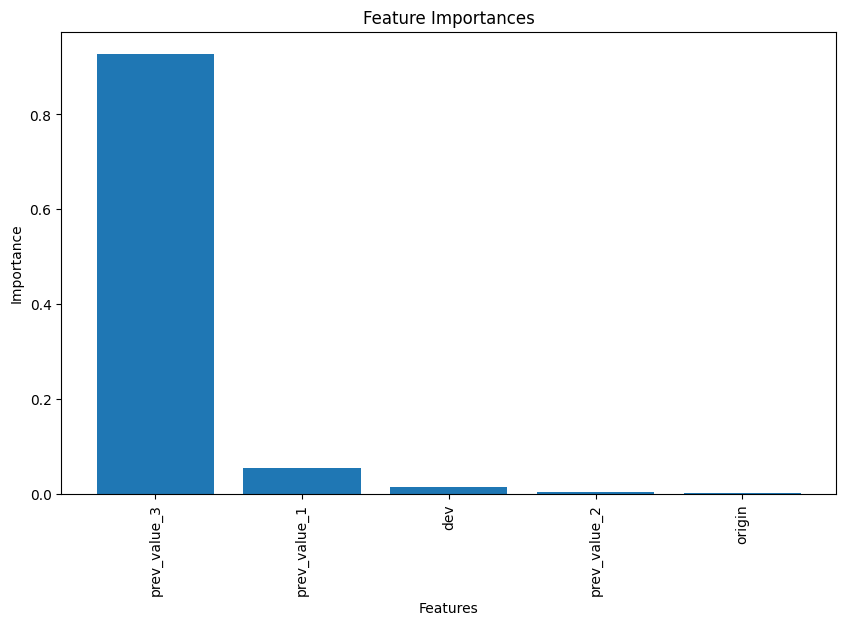

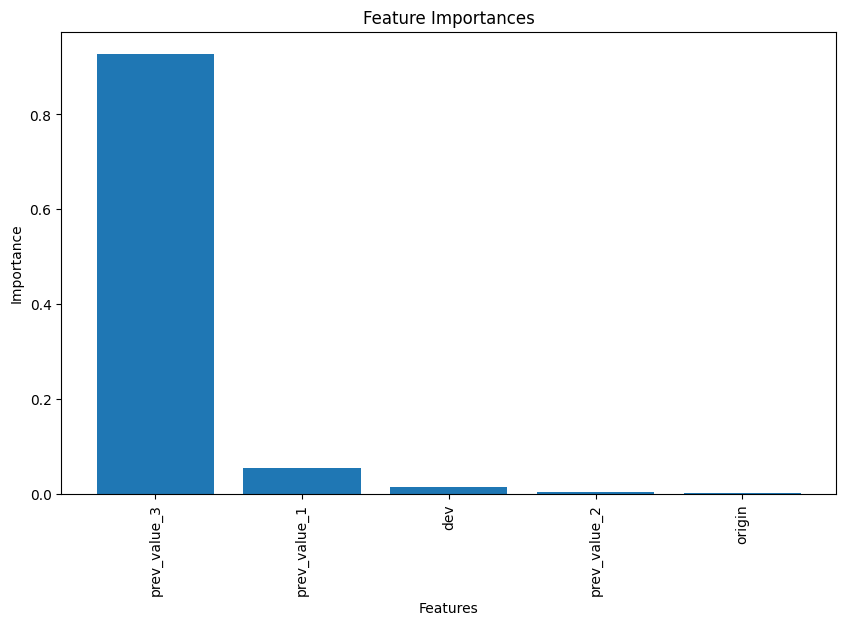

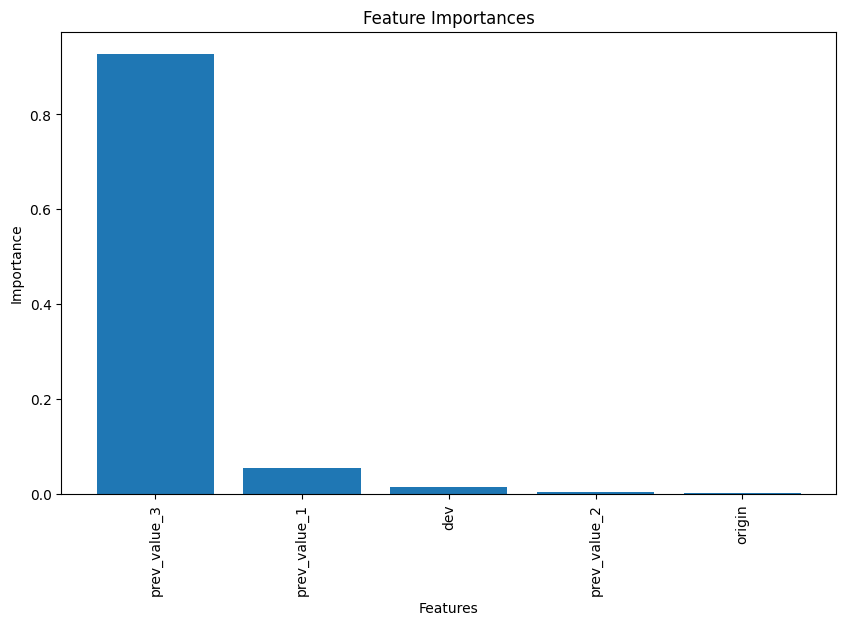

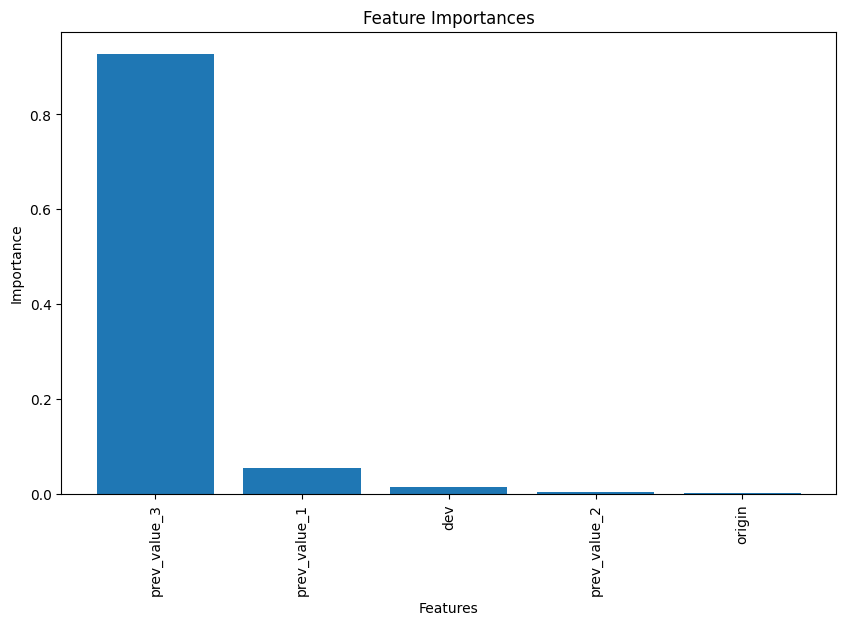

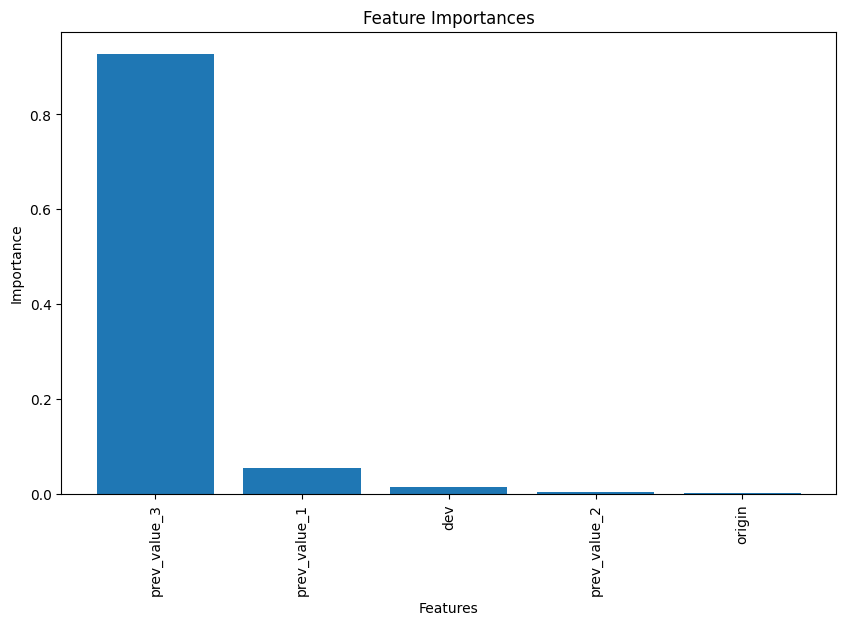

In [ ]:
layers = [1, 2, 3]
neurons = [16, 32, 64, 128]
batch_sizes = [16, 32, 64]
times1_lstm, rmse_lstm, rmse_val_lstm, r2_lstm, r2_val_lstm = [], [], [], [], []
mini_rmse_lstm, maxi_r2_lstm, mini_rmse_val_lstm, maxi_r2_val_lstm = 10000000000, 0, 100000000, 0
for layer in layers:
    for neuron in neurons:
        for batch_size in batch_sizes:
            start_time = time.time()
            if layer == 1:
                x = LSTM(neuron, return_sequences=False)(seq_input)
                x = Dropout(0.1)(x)
                x = Dense(neuron, activation='relu')(x)
            if layer > 1:
                x = LSTM(neuron, return_sequences=True)(seq_input)
                x = Dropout(0.1)(x)
                x = LSTM(neuron)(x) 
                x = Dropout(0.1)(x)
            if layer > 2:
                x = LSTM(neuron, return_sequences=True)(seq_input)
                x = Dropout(0.1)(x)
                x = LSTM(neuron, return_sequences=True)(x) 
                x = Dropout(0.1)(x)
                x = LSTM(neuron)(x) 
                x = Dropout(0.1)(x)
            if layer > 1:
                x = Concatenate()([x, prev_input])
            if neuron > 16:
                if neuron > 32:
                    if neuron > 64:
                        x = Dense(64, activation='relu')(x)
                    x = Dense(32, activation='relu')(x)
                x = Dense(16, activation='relu')(x)         

            output = Dense(1)(x)

            model_lstm = Model(inputs=[seq_input, prev_input], outputs=output)
            model_lstm.compile(optimizer='adam', loss='mse')
            model_lstm.fit([X_seq_train, X_prev_train], y_train_dl, epochs=100, batch_size=batch_size,
                           validation_data=([X_seq_val, X_prev_val], y_val_dl), callbacks=[early_stop], verbose=0)
            end_time = time.time()
            times1_lstm.append(round(end_time - start_time, 2))

            y_pred_lstm = model_lstm.predict([X_seq_test, X_prev_test], verbose=0)
            mse_lstm = mean_squared_error(y_test_dl, y_pred_lstm)
            rmse_lstm.append(round(np.sqrt(mse_lstm)))
            r2_lstm.append(round(r2_score(y_test_dl, y_pred_lstm), 4))

            y_val_pred_dl = model_lstm.predict([X_seq_val, X_prev_val], verbose=0)
            mse_val_dl = mean_squared_error(y_val_dl, y_val_pred_dl)
            rmse_val_lstm.append(round(np.sqrt(mse_val_dl)))
            r2_val_lstm.append(round(r2_score(y_val_dl, y_val_pred_dl), 4))

In [19]:
X_combined_, y_ = generate_sequences_all_triangles(triangles_)

X_seq_raw_ = [x[0] for x in X_combined_]
X_prev_ = np.array([x[1] for x in X_combined_])
y_ = np.array(y_)

X_seq_padded_ = pad_sequences(X_seq_raw_, padding='pre', dtype='float32')

X_seq_temp_, X_seq_test_, X_prev_temp_, X_prev_test_, y_temp_dl_, y_test_dl_ = train_test_split(X_seq_padded_, X_prev_, y_, test_size = 0.2)
X_seq_train_, X_seq_val_, X_prev_train_, X_prev_val_, y_train_dl_, y_val_dl_ = train_test_split(X_seq_temp_, X_prev_temp_, y_temp_dl_, test_size = 0.25)
seq_input_ = Input(shape=(X_seq_train_.shape[1], X_seq_train_.shape[2]))
prev_input_ = Input(shape=(1,))

In [20]:
times1_lstm_, rmse_lstm_, rmse_val_lstm_, r2_lstm_, r2_val_lstm_ = [], [], [], [], []
mini_rmse_lstm_, maxi_r2_lstm_, mini_rmse_val_lstm_, maxi_r2_val_lstm_ = 10000000000, 0, 100000000, 0
for layer in layers:
    for neuron in neurons:
        for batch_size in batch_sizes:
            start_time = time.time()
            if layer == 1:
                x = LSTM(neuron, return_sequences=False)(seq_input_)
                x = Dropout(0.1)(x)
                x = Dense(neuron, activation='relu')(x)
            if layer > 1:
                x = LSTM(neuron, return_sequences=True)(seq_input_)
                x = Dropout(0.1)(x)
                x = LSTM(neuron)(x) 
                x = Dropout(0.1)(x)
            if layer > 2:
                x = LSTM(neuron, return_sequences=True)(seq_input_)
                x = Dropout(0.1)(x)
                x = LSTM(neuron, return_sequences=True)(x) 
                x = Dropout(0.1)(x)
                x = LSTM(neuron)(x) 
                x = Dropout(0.1)(x)
            if layer > 1:
                x = Concatenate()([x, prev_input_])
            if neuron > 16:
                if neuron > 32:
                    if neuron > 64:
                        x = Dense(64, activation='relu')(x)
                    x = Dense(32, activation='relu')(x)
                x = Dense(16, activation='relu')(x)     

            output_ = Dense(1)(x)

            model_lstm_ = Model(inputs=[seq_input_, prev_input_], outputs=output_)
            model_lstm_.compile(optimizer='adam', loss='mse')
            model_lstm_.fit([X_seq_train_, X_prev_train_], y_train_dl_, epochs=100, batch_size=batch_size,
                            validation_data=([X_seq_val_, X_prev_val_], y_val_dl_), callbacks=[early_stop], verbose=0)
            end_time = time.time()
            times1_lstm_.append(round(end_time - start_time, 2))

            y_pred_lstm_ = model_lstm_.predict([X_seq_test_, X_prev_test_], verbose=0)
            mse_lstm_ = mean_squared_error(y_test_dl_, y_pred_lstm_)
            rmse_lstm_.append(round(np.sqrt(mse_lstm_)))
            r2_lstm_.append(round(r2_score(y_test_dl_, y_pred_lstm_), 4))

            y_val_pred_dl_ = model_lstm_.predict([X_seq_val_, X_prev_val_], verbose=0)
            mse_val_dl_ = mean_squared_error(y_val_dl_, y_val_pred_dl_)
            rmse_val_lstm_.append(round(np.sqrt(mse_val_dl_)))
            r2_val_lstm_.append(round(r2_score(y_val_dl_, y_val_pred_dl_), 4))

In [21]:
table_lstm = pd.DataFrame({
    "Number of layers": [layer for layer in layers for _ in range(len(neurons) * len(batch_sizes))],
    "Number of neurons": [neuron for _ in range(len(batch_sizes)) for neuron in neurons for _ in range(len(layers))],
    "Batch size": batch_sizes * len(neurons) * len(layers),
    "RMSE": rmse_lstm,
    "R^2": r2_lstm,
    "RMSE_val": rmse_val_lstm,
    "R^2_val": r2_val_lstm,
    "Time": times1_lstm
})
table_lstm_ = pd.DataFrame({
    "Number of layers": [layer for layer in layers for _ in range(len(neurons) * len(batch_sizes))],
    "Number of neurons": [neuron for _ in range(len(batch_sizes)) for neuron in neurons for _ in range(len(layers))],
    "Batch size": batch_sizes * len(neurons) * len(layers),
    "RMSE": rmse_lstm_,
    "R^2": r2_lstm_,
    "RMSE_val": rmse_val_lstm_,
    "R^2_val": r2_val_lstm_,
    "Time": times1_lstm_
})

In [22]:
print(table_lstm.to_latex(index=False,
                  column_format = '|c|c|c|c|c|c|c|c|',
                  float_format=lambda x: ('%g' % x)))

\begin{tabular}{|c|c|c|c|c|c|c|c|}
\toprule
Number of layers & Number of neurons & Batch size & RMSE & R^2 & RMSE_val & R^2_val & Time \\
\midrule
1 & 16 & 16 & 253926 & -0.1722 & 241949 & -0.1702 & 63.58 \\
1 & 16 & 32 & 256028 & -0.1916 & 244046 & -0.1906 & 42.99 \\
1 & 16 & 64 & 257454 & -0.205 & 245416 & -0.204 & 28.98 \\
1 & 32 & 16 & 227407 & 0.0599 & 214540 & 0.0799 & 48.24 \\
1 & 32 & 32 & 236286 & -0.015 & 224774 & -0.01 & 22.97 \\
1 & 32 & 64 & 243312 & -0.0762 & 231492 & -0.0713 & 17.48 \\
1 & 64 & 16 & 224426 & 0.0844 & 211737 & 0.1038 & 24.1 \\
1 & 64 & 32 & 225137 & 0.0786 & 213987 & 0.0846 & 20.26 \\
1 & 64 & 64 & 229471 & 0.0427 & 215661 & 0.0702 & 11.76 \\
1 & 128 & 16 & 219763 & 0.122 & 207428 & 0.1399 & 29.66 \\
1 & 128 & 32 & 220518 & 0.116 & 208168 & 0.1337 & 14.19 \\
1 & 128 & 64 & 221491 & 0.1082 & 207456 & 0.1397 & 15.65 \\
2 & 16 & 16 & 129336 & 0.6959 & 118926 & 0.7173 & 55.77 \\
2 & 16 & 32 & 129393 & 0.6956 & 118974 & 0.717 & 24.42 \\
2 & 16 & 64 & 129379 & 

In [23]:
print(table_lstm_.to_latex(index=False,
                  column_format = '|c|c|c|c|c|c|c|c|',
                  float_format=lambda x: ('%g' % x)))

\begin{tabular}{|c|c|c|c|c|c|c|c|}
\toprule
Number of layers & Number of neurons & Batch size & RMSE & R^2 & RMSE_val & R^2_val & Time \\
\midrule
1 & 16 & 16 & 1671477 & -0.6771 & 1647217 & -0.6804 & 81.5 \\
1 & 16 & 32 & 1698122 & -0.731 & 1673961 & -0.7355 & 51.41 \\
1 & 16 & 64 & 1710080 & -0.7554 & 1685969 & -0.7604 & 30.21 \\
1 & 32 & 16 & 1295654 & -0.0077 & 1269979 & 0.0011 & 82.48 \\
1 & 32 & 32 & 1297024 & -0.0098 & 1274424 & -0.0059 & 31.58 \\
1 & 32 & 64 & 1306913 & -0.0253 & 1284459 & -0.0218 & 36.06 \\
1 & 64 & 16 & 1296538 & -0.0091 & 1270035 & 0.001 & 31.43 \\
1 & 64 & 32 & 1296500 & -0.009 & 1269133 & 0.0024 & 51.82 \\
1 & 64 & 64 & 1295638 & -0.0077 & 1269742 & 0.0015 & 19.35 \\
1 & 128 & 16 & 1295289 & -0.0071 & 1268879 & 0.0028 & 46.22 \\
1 & 128 & 32 & 1293885 & -0.0049 & 1267961 & 0.0043 & 14.29 \\
1 & 128 & 64 & 1293354 & -0.0041 & 1268371 & 0.0036 & 31.03 \\
2 & 16 & 16 & 230709 & 0.968 & 240447 & 0.9642 & 39.7 \\
2 & 16 & 32 & 230662 & 0.9681 & 240526 & 0.9642 

In [31]:
t1 = time.time()
model_GBR = XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=5, eval_metric = mean_squared_error)
model_GBR.fit(X_train, y_train, eval_set = [(X_val, y_val)], verbose = True)
t2 = time.time()
print(f"Training time: {t2 - t1:.2f} seconds")
t3 = time.time()
completed_triangles_gbr = model_prediction_gb(triangles, model_GBR)
t4 = time.time()
print(f"Prediction time: {t4 - t3:.2f} seconds")

y_pred_GBR = model_GBR.predict(X_test)
mse_GBR = mean_squared_error(y_test, y_pred_GBR)
rmse_GBR = np.sqrt(mse_GBR)
r2_GBR = r2_score(y_test, y_pred_GBR)

print(f"Root Mean Squared Error (RMSE): {rmse_GBR:.2f}")
print(f"R² Score: {r2_GBR:.4f}")

y_val_pred = model_GBR.predict(X_val)
mse_val = mean_squared_error(y_val, y_val_pred)
rmse_val = np.sqrt(mse_val)
r2_val = r2_score(y_val, y_val_pred)

print(f"Validation RMSE: {rmse_val:.2f}")
print(f"Validation R²: {r2_val:.4f}")

[0]	validation_0-rmse:218356.69504	validation_0-mean_squared_error:47679643648.00000


[1]	validation_0-rmse:198941.15588	validation_0-mean_squared_error:39577583616.00000
[2]	validation_0-rmse:181681.25772	validation_0-mean_squared_error:33008078848.00000
[3]	validation_0-rmse:166517.93000	validation_0-mean_squared_error:27728220160.00000
[4]	validation_0-rmse:153140.74686	validation_0-mean_squared_error:23452086272.00000
[5]	validation_0-rmse:141012.76288	validation_0-mean_squared_error:19884599296.00000
[6]	validation_0-rmse:130641.06362	validation_0-mean_squared_error:17067087872.00000
[7]	validation_0-rmse:121060.44848	validation_0-mean_squared_error:14655632384.00000
[8]	validation_0-rmse:112711.65557	validation_0-mean_squared_error:12703918080.00000
[9]	validation_0-rmse:105519.04239	validation_0-mean_squared_error:11134268416.00000
[10]	validation_0-rmse:98916.14698	validation_0-mean_squared_error:9784404992.00000
[11]	validation_0-rmse:93180.43489	validation_0-mean_squared_error:8682593280.00000
[12]	validation_0-rmse:88217.71362	validation_0-mean_squared_error:

In [32]:
t1 = time.time()
model_GBR_ = XGBRegressor(n_estimators=500, learning_rate=0.2, max_depth=6, eval_metric = mean_squared_error)
model_GBR_.fit(X_train_, y_train_, eval_set = [(X_val_, y_val_)], verbose = True)
t2 = time.time()
print(f"Training time: {t2 - t1:.2f} seconds")
t3 = time.time()
completed_triangles_gbr_ = model_prediction_gb(triangles_, model_GBR_)
t4 = time.time()
print(f"Prediction time: {t4 - t3:.2f} seconds")

y_pred_GBR_ = model_GBR_.predict(X_test_)
mse_GBR_ = mean_squared_error(y_test_, y_pred_GBR_)
rmse_GBR_ = np.sqrt(mse_GBR_)
r2_GBR_ = r2_score(y_test_, y_pred_GBR_)

print(f"Root Mean Squared Error (RMSE): {rmse_GBR_:.2f}")
print(f"R² Score: {r2_GBR_:.4f}")

y_val_pred_ = model_GBR_.predict(X_val_)
mse_val_ = mean_squared_error(y_val_, y_val_pred_)
rmse_val_ = np.sqrt(mse_val_)
r2_val_ = r2_score(y_val_, y_val_pred_)

print(f"Validation RMSE: {rmse_val_:.2f}")
print(f"Validation R²: {r2_val_:.4f}")

[0]	validation_0-rmse:1038257.64830	validation_0-mean_squared_error:1077978988544.00000
[1]	validation_0-rmse:838382.32968	validation_0-mean_squared_error:702885003264.00000
[2]	validation_0-rmse:677524.57021	validation_0-mean_squared_error:459039539200.00000
[3]	validation_0-rmse:548740.91192	validation_0-mean_squared_error:301116588032.00000
[4]	validation_0-rmse:446348.69606	validation_0-mean_squared_error:199227162624.00000
[5]	validation_0-rmse:365143.18482	validation_0-mean_squared_error:133329543168.00000
[6]	validation_0-rmse:299465.31068	validation_0-mean_squared_error:89679470592.00000
[7]	validation_0-rmse:246451.34100	validation_0-mean_squared_error:60738265088.00000
[8]	validation_0-rmse:205895.37648	validation_0-mean_squared_error:42392903680.00000
[9]	validation_0-rmse:172521.61658	validation_0-mean_squared_error:29763708928.00000
[10]	validation_0-rmse:146006.19886	validation_0-mean_squared_error:21317810176.00000
[11]	validation_0-rmse:125745.52063	validation_0-mean_sq

In [33]:
test_triangles = triangles.copy()
true_triangles = test_triangles.copy()

masked_triangles = hide_values_for_backtest(test_triangles, start_from=3)
train_df_bt = prepare_training_data_with_previous_values(masked_triangles)
X_bt, y_bt = train_df_bt[["origin", "dev"] + [f"prev_value_{i}" for i in range(1, 4)]], train_df_bt["value"]

model_bt_gbr = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6)
model_bt_gbr.fit(X_bt, y_bt)
completed_gbr = model_prediction_gb(masked_triangles, model_bt_gbr)

y_true, y_pred = [], []
for triangle_pred, triangle_true in zip(completed_gbr, true_triangles):
    size = triangle_pred.shape[0]
    for i in range(3, size):
        for j in range(3, size):
            if i + j < size:
                y_true.append(triangle_true[i, j])
                y_pred.append(triangle_pred[i, j])

# Metryki
print("--- BACKTEST---")
print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")
print(f"R²: {r2_score(y_true, y_pred):.4f}")

--- BACKTEST---
RMSE: 24258.93
R²: 0.7772


In [34]:
test_triangles_ = triangles_.copy()
true_triangles_ = test_triangles_.copy()

masked_triangles_ = hide_values_for_backtest(test_triangles_, start_from=3)
train_df_bt_ = prepare_training_data_with_previous_values(masked_triangles_)
X_bt_, y_bt_ = train_df_bt_[["origin", "dev"] + [f"prev_value_{i}" for i in range(1, 4)]], train_df_bt_["value"]

model_bt_gbr_ = XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=7)
model_bt_gbr_.fit(X_bt_, y_bt_)
completed_gbr_ = model_prediction_gb(masked_triangles_, model_bt_gbr_)

y_true_, y_pred_ = [], []
for triangle_pred, triangle_true in zip(completed_gbr_, true_triangles_):
    size = triangle_pred.shape[0]
    for i in range(3, size):
        for j in range(3, size):
            if i + j < size:
                y_true_.append(triangle_true[i, j])
                y_pred_.append(triangle_pred[i, j])

# Metryki
print("--- BACKTEST---")
print(f"RMSE: {np.sqrt(mean_squared_error(y_true_, y_pred_)):.2f}")
print(f"R²: {r2_score(y_true_, y_pred_):.4f}")

--- BACKTEST---
RMSE: 97823.82
R²: 0.9945


In [36]:
t1 = time.time()
x = LSTM(128, return_sequences=True)(seq_input)
x = Dropout(0.1)(x)
x = LSTM(128, return_sequences=True)(x) 
x = Dropout(0.1)(x)
x = LSTM(128)(x) 
x = Dropout(0.1)(x)
x = Concatenate()([x, prev_input])

x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)

output = Dense(1)(x)

model_lstm = Model(inputs=[seq_input, prev_input], outputs=output)
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit([X_seq_train, X_prev_train], y_train_dl, epochs=100, batch_size=16,
               validation_data=([X_seq_val, X_prev_val], y_val_dl), callbacks=[early_stop])
t2 = time.time()
print(f"Training time: {t2 - t1:.2f} seconds")

y_pred_lstm = model_lstm.predict([X_seq_test, X_prev_test])
mse_lstm = mean_squared_error(y_test_dl, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_test_dl, y_pred_lstm)

print(f"Root Mean Squared Error (RMSE): {rmse_lstm:.2f}")
print(f"R² Score: {r2_lstm:.4f}")

y_val_pred_dl = model_lstm.predict([X_seq_val, X_prev_val])
mse_val_dl = mean_squared_error(y_val_dl, y_val_pred_dl)
rmse_val_dl = np.sqrt(mse_val_dl)
r2_val_dl = r2_score(y_val_dl, y_val_pred_dl)

print(f"Validation RMSE: {rmse_val_dl:.2f}")
print(f"Validation R²: {r2_val_dl:.4f}")

Epoch 1/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 33797449728.0000 - val_loss: 14418979840.0000
Epoch 2/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 16049034240.0000 - val_loss: 14258377728.0000
Epoch 3/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 17231204352.0000 - val_loss: 14455124992.0000
Epoch 4/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 17657696256.0000 - val_loss: 14164338688.0000
Epoch 5/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 18951069696.0000 - val_loss: 14172313600.0000
Epoch 6/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 15107372032.0000 - val_loss: 14172909568.0000
Epoch 7/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 18383923200.0000 - val_loss: 14221409280.0000
Epoch 8/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 15252218880.0000 - val_loss: 14188068864.0000
Epoch 9/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 14932370432.0000 - val_loss: 14145745920.0000
Epoch 10/100
288/288 ━━━━━━

In [37]:
t1 = time.time()
x = LSTM(128, return_sequences=True)(seq_input_)
x = Dropout(0.1)(x)
x = LSTM(128)(x)
x = Dropout(0.1)(x)
x = Concatenate()([x, prev_input_])

x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
output_ = Dense(1)(x)

model_lstm_ = Model(inputs=[seq_input_, prev_input_], outputs=output_)
model_lstm_.compile(optimizer='adam', loss='mse')
model_lstm_.fit([X_seq_train_, X_prev_train_], y_train_dl_, epochs=100, batch_size=32,
                validation_data=([X_seq_val_, X_prev_val_], y_val_dl_), callbacks=[early_stop])
t2 = time.time()
print(f"Training time: {t2 - t1:.2f} seconds")

y_pred_lstm_ = model_lstm_.predict([X_seq_test_, X_prev_test_])
mse_lstm_ = mean_squared_error(y_test_dl_, y_pred_lstm_)
rmse_lstm_ = np.sqrt(mse_lstm_)
r2_lstm_ = r2_score(y_test_dl_, y_pred_lstm_)

print(f"Root Mean Squared Error (RMSE): {rmse_lstm_:.2f}")
print(f"R² Score: {r2_lstm_:.4f}")

y_val_pred_dl_ = model_lstm_.predict([X_seq_val_, X_prev_val_])
mse_val_dl_ = mean_squared_error(y_val_dl_, y_val_pred_dl_)
rmse_val_dl_ = np.sqrt(mse_val_dl_)
r2_val_dl_ = r2_score(y_val_dl_, y_val_pred_dl_)

print(f"Validation RMSE: {rmse_val_dl_:.2f}")
print(f"Validation R²: {r2_val_dl_:.4f}")

Epoch 1/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 805798019072.0000 - val_loss: 58010411008.0000
Epoch 2/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 55648362496.0000 - val_loss: 60237463552.0000
Epoch 3/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 52906569728.0000 - val_loss: 58697826304.0000
Epoch 4/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 53255905280.0000 - val_loss: 57890033664.0000
Epoch 5/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 50029412352.0000 - val_loss: 57898520576.0000
Epoch 6/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 56748556288.0000 - val_loss: 57747386368.0000
Epoch 7/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 53373468672.0000 - val_loss: 58215882752.0000
Epoch 8/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 50807537664.0000 - val_loss: 57653493760.0000
Epoch 9/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 54206541824.0000 - val_loss: 58316476416.0000
Epoch 10/100
144/144 ━━━━━━

In [55]:
t1 = time.time()
completed_triangles_lstm_ = model_prediction_dl(triangles_, model_lstm_)
t2 = time.time()
print(f"Prediction time: {t2 - t1:.2f} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

In [56]:
t1 = time.time()
completed_triangles_lstm = model_prediction_dl(triangles, model_lstm)
t2 = time.time()
print(f"Prediction time: {t2 - t1:.2f} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

In [57]:
X_combined_bt, y_bt = generate_sequences_all_triangles(masked_triangles)

X_seq_raw_bt = [x[0] for x in X_combined_bt]
X_prev_bt = np.array([x[1] for x in X_combined_bt])
y_bt = np.array(y_bt)

X_seq_padded_bt = pad_sequences(X_seq_raw_bt, padding='pre', dtype='float32')

X_seq_temp_bt, X_seq_test_bt, X_prev_temp_bt, X_prev_test_bt, y_temp_dl_bt, y_test_dl_bt = train_test_split(X_seq_padded_bt, X_prev_bt, y_bt, test_size = 0.2)
X_seq_train_bt, X_seq_val_bt, X_prev_train_bt, X_prev_val_bt, y_train_dl_bt, y_val_dl_bt = train_test_split(X_seq_temp_bt, X_prev_temp_bt, y_temp_dl_bt, test_size = 0.25)
seq_input_bt = Input(shape=(X_seq_train_bt.shape[1], X_seq_train_bt.shape[2]))
prev_input_bt = Input(shape=(1,))

In [58]:
t1 = time.time()
x = LSTM(128, return_sequences=True)(seq_input_bt)
x = Dropout(0.1)(x)
x = LSTM(128, return_sequences=True)(x) 
x = Dropout(0.1)(x)
x = LSTM(128)(x)
x = Dropout(0.1)(x)
x = Concatenate()([x, prev_input_bt])

x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)

output_lstm_bt = Dense(1)(x)

model_lstm_bt = Model(inputs=[seq_input_bt, prev_input_bt], outputs=output_lstm_bt)
model_lstm_bt.compile(optimizer='adam', loss='mse')
model_lstm_bt.fit([X_seq_train_bt, X_prev_train_bt], y_train_dl_bt, epochs=100, batch_size=16, 
                  validation_data=([X_seq_val_bt, X_prev_val_bt], y_val_dl_bt), callbacks=[early_stop])
t2 = time.time()
print(f"Training time: {t2 - t1:.2f} seconds")
t3 = time.time()
completed_lstm_bt = model_prediction_dl(masked_triangles, model_lstm_bt)
t4 = time.time()
print(f"Prediction time: {t4 - t3:.2f} seconds")
y_true, y_pred = [], []
for triangle_pred, triangle_true in zip(completed_lstm_bt, true_triangles):
    size = triangle_pred.shape[0]
    for i in range(3, size):
        for j in range(3, size):
            if i + j < size:
                y_true.append(triangle_true[i, j])
                y_pred.append(triangle_pred[i, j])

# Metryki
print("--- BACKTEST---")
print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")
print(f"R²: {r2_score(y_true, y_pred):.4f}")

Epoch 1/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 46726172672.0000 - val_loss: 25717610496.0000
Epoch 2/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 23602518016.0000 - val_loss: 25394171904.0000
Epoch 3/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 16699246592.0000 - val_loss: 25290874880.0000
Epoch 4/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 18923542528.0000 - val_loss: 25320947712.0000
Epoch 5/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 20474122240.0000 - val_loss: 25395386368.0000
Epoch 6/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 20114309120.0000 - val_loss: 25349322752.0000
Epoch 7/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 20035926016.0000 - val_loss: 25267056640.0000
Epoch 8/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 19879276544.0000 - val_loss: 25219903488.0000
Epoch 9/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 19529889792.0000 - val_loss: 25388177408.0000
Epoch 10/100
208/208 ━━━━━━━

In [59]:
X_combined_bt, y_bt = generate_sequences_all_triangles(masked_triangles_)

X_seq_raw_bt = [x[0] for x in X_combined_bt]
X_prev_bt = np.array([x[1] for x in X_combined_bt])
y_bt = np.array(y_bt)

X_seq_padded_bt = pad_sequences(X_seq_raw_bt, padding='pre', dtype='float32')

X_seq_temp_bt, X_seq_test_bt, X_prev_temp_bt, X_prev_test_bt, y_temp_dl_bt, y_test_dl_bt = train_test_split(X_seq_padded_bt, X_prev_bt, y_bt, test_size = 0.2)
X_seq_train_bt, X_seq_val_bt, X_prev_train_bt, X_prev_val_bt, y_train_dl_bt, y_val_dl_bt = train_test_split(X_seq_temp_bt, X_prev_temp_bt, y_temp_dl_bt, test_size = 0.25)
seq_input_bt = Input(shape=(X_seq_train_bt.shape[1], X_seq_train_bt.shape[2]))
prev_input_bt = Input(shape=(1,))

In [60]:
t1 = time.time()
x = LSTM(128, return_sequences=True)(seq_input_bt)
x = Dropout(0.1)(x)
x = LSTM(128)(x)
x = Dropout(0.1)(x)
x = Concatenate()([x, prev_input_bt])

x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)

output_lstm_bt = Dense(1)(x)

model_lstm_bt = Model(inputs=[seq_input_bt, prev_input_bt], outputs=output_lstm_bt)
model_lstm_bt.compile(optimizer='adam', loss='mse')
model_lstm_bt.fit([X_seq_train_bt, X_prev_train_bt], y_train_dl_bt, epochs=100, batch_size=16, 
                  validation_data=([X_seq_val_bt, X_prev_val_bt], y_val_dl_bt), callbacks=[early_stop])
t2 = time.time()
print(f"Training time: {t2 - t1:.2f} seconds")
t3 = time.time()
completed_lstm_bt = model_prediction_dl(masked_triangles_, model_lstm_bt)
t4 = time.time()
print(f"Prediction time: {t4 - t3:.2f} seconds")
y_true, y_pred = [], []
for triangle_pred, triangle_true in zip(completed_lstm_bt, true_triangles_):
    size = triangle_pred.shape[0]
    for i in range(3, size):
        for j in range(3, size):
            if i + j < size:
                y_true.append(triangle_true[i, j])
                y_pred.append(triangle_pred[i, j])

print("--- BACKTEST---")
print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")
print(f"R²: {r2_score(y_true, y_pred):.4f}")

Epoch 1/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 1140287864832.0000 - val_loss: 56372269056.0000
Epoch 2/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 71009689600.0000 - val_loss: 57894457344.0000
Epoch 3/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 77208346624.0000 - val_loss: 54801575936.0000
Epoch 4/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 65826992128.0000 - val_loss: 55725203456.0000
Epoch 5/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 70807134208.0000 - val_loss: 55066144768.0000
Epoch 6/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 69740535808.0000 - val_loss: 54841466880.0000
Epoch 7/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 66707660800.0000 - val_loss: 54734721024.0000
Epoch 8/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 69161648128.0000 - val_loss: 55432114176.0000
Epoch 9/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 65803808768.0000 - val_loss: 57763135488.0000
Epoch 10/100
208/208 ━━━━━━━━━━━━

In [7]:
#np.save("gbr_noncum.npy", completed_triangles_gbr)
#np.save("gbr_cum.npy", completed_triangles_gbr_)
#np.save("lstm_noncum.npy", completed_triangles_lstm)
#np.save("lstm_cum.npy", completed_triangles_lstm_)
lstm_cum = np.load("lstm_cum.npy")
lstm_noncum = np.load("lstm_noncum.npy")
gbr_cum = np.load("gbr_cum.npy")
gbr_noncum = np.load("gbr_noncum.npy")

In [8]:
ibnr_mack, ibnr_hertig, ibnr_lstm, ibnr_lstm_, ibnr_gbr, ibnr_gbr_, min, max = [], [], [], [], [], [], 10000, 0
for i in range(len(data)):
    ibnr_mack.append(np.mean(res_mack[i][3]))
    ibnr_hertig.append(np.mean(res_hertig[i][3]))
    ibnr_lstm.append(return_ibnr_non_cum(lstm_noncum[i]))
    ibnr_lstm_.append(return_ibnr_cum(lstm_cum[i]))
    ibnr_gbr.append(return_ibnr_non_cum(gbr_noncum[i]))
    ibnr_gbr_.append(return_ibnr_cum(gbr_cum[i]))

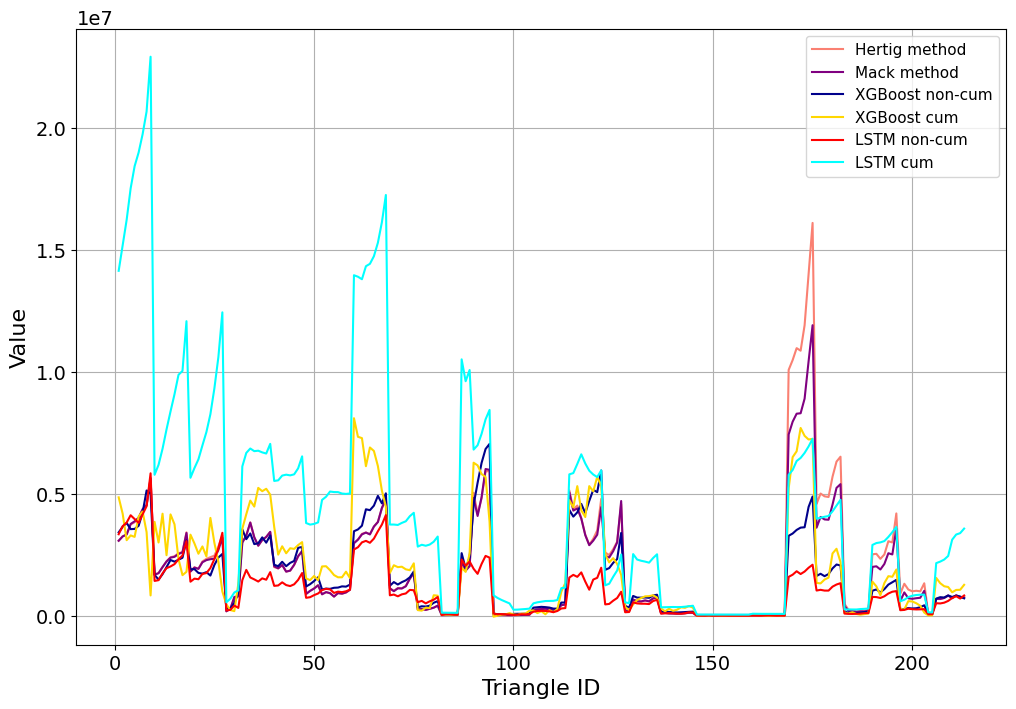

In [9]:
plt.figure(figsize = (12, 8))
ax = plt.gca()
plt.plot(np.linspace(1, len(data), len(data)), ibnr_hertig, color = 'salmon', label = 'Hertig method')
plt.plot(np.linspace(1, len(data), len(data)), ibnr_mack, color = 'purple', label = 'Mack method')
plt.plot(np.linspace(1, len(data), len(data)), ibnr_gbr, color = 'darkblue', label = 'XGBoost non-cum')
plt.plot(np.linspace(1, len(data), len(data)), ibnr_gbr_, color = 'gold', label = 'XGBoost cum')
plt.plot(np.linspace(1, len(data), len(data)), ibnr_lstm, color = 'red', label = 'LSTM non-cum')
plt.plot(np.linspace(1, len(data), len(data)), ibnr_lstm_, color = 'cyan', label = 'LSTM cum')
plt.xlabel('Triangle ID', fontsize = 16)
plt.ylabel('Value', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
ax.yaxis.offsetText.set_fontsize(14)
plt.grid()
plt.legend(fontsize = 11)
plt.show()

In [10]:
def complete(startindex, years):
    rows = []
    for i in range(years):
        rows.append(data[startindex + i].iloc[0, :])
    if years < 10:
        rows.append(data[startindex + i].iloc[1, :])
        if years < 9:
            rows.append(data[startindex + i].iloc[2, :])
            if years < 8:
                rows.append(data[startindex + i].iloc[3, :])
                if years < 7:
                    rows.append(data[startindex + i].iloc[4, :])
                    if years < 6:
                        rows.append(data[startindex + i].iloc[5, :])
                        if years < 5:
                            rows.append(data[startindex + i].iloc[6, :])
                            if years < 4:
                                rows.append(data[startindex + i].iloc[7, :])
                                if years < 3:
                                    rows.append(data[startindex + i].iloc[8, :])
    table = pd.DataFrame(rows, index=[i for i in range(10)], columns=[i for i in range(10)])
    return table

def cum(table):
    for i in range(10):
        for j in range(1, 10):
            if table.iloc[i, j] is not None and not pd.isna(table.iloc[i, j]):
                table.iloc[i, j] = table.iloc[i, j] + table.iloc[i, j-1]
    return table 

def uncum(table):
    for i in range(9, -1, -1):
        for j in range(9, 0, -1):
            if table.iloc[i, j] is not None and not pd.isna(table.iloc[i, j]):
                table.iloc[i, j] = table.iloc[i, j] - table.iloc[i, j-1]
    return table 

In [11]:
for k in range(len(data)):
    lstm_noncum[k] = cum(pd.DataFrame(lstm_noncum[k]))
    gbr_noncum[k] = cum(pd.DataFrame(gbr_noncum[k]))

In [12]:
rows = []
for i in range(8):
    if i == 0:
        rows.append(data[68].iloc[0, :])
    if i == 1:
        rows.append(data[68].iloc[1, :])
    if i > 1:
        rows.append(data[68 + i - 1].iloc[0, :])
rows.append(data[68 + 6].iloc[1, :])
rows.append(data[68 + 6].iloc[2, :])
groupama_table = cum(pd.DataFrame(rows, index=[i for i in range(10)], columns=[i for i in range(10)]))

In [13]:
rows = []
for i in range(9):
    if i == 0:
        rows.append(data[129].iloc[0, :])
    if i == 1:
        rows.append(data[129].iloc[1, :])
    if i == 5:
        rows.append(data[129 + i - 2].iloc[1, :])
    if 1 < i < 8:
        rows.append(data[129 + i - 1].iloc[0, :])
rows.append(data[129 + 6].iloc[1, :])
hdige_table = cum(pd.DataFrame(rows, index=[i for i in range(10)], columns=[i for i in range(10)]))

# CONFIDENCE INTERVALS

In [14]:
pzu_table = cum(complete(0, 9))
ergo_table = cum(complete(9, 9))
warta_table = cum(complete(18, 9))
alianzfr_table = cum(complete(31, 8))
alianzit_table = cum(complete(39, 8))
alianzes_table = cum(complete(51, 8))
alianzge_table = cum(complete(59, 9))
globalse_table = cum(complete(113, 9))
hdiaus_table = cum(complete(136, 9))
lpv_table = cum(complete(145, 9))
targo_table = cum(complete(159, 9))
#generali_table = cum(complete(205, 7))
tables = [pzu_table, ergo_table, warta_table, alianzfr_table, alianzit_table, alianzes_table,
          alianzge_table, groupama_table, globalse_table, hdige_table, hdiaus_table, lpv_table, targo_table]
indices = [0, 9, 18, 31, 39, 51, 59, 68, 113, 129, 136, 145, 159]

In [15]:
l_gbr_mack, l_lstm_mack, l_gbr_mack_, l_lstm_mack_, l_hertig, l, l_, l_real = 0, 0, 0, 0, 0, 0, 0, 0
for k in range(len(data)):
    for i in range(10):
        for j in range(10):
            if not pd.isna(res_mack[k][-1].iloc[i, j]):
                if np.abs(gbr_cum[k][i, j] - res_mack[k][2].iloc[i, j]) < res_mack[k][-1].iloc[i, j]:
                    l_gbr_mack_ += 1
                if np.abs(gbr_noncum[k][i, j] - res_mack[k][2].iloc[i, j]) < res_mack[k][-1].iloc[i, j]:
                    l_gbr_mack += 1
                if np.abs(lstm_cum[k][i, j] - res_mack[k][2].iloc[i, j]) < res_mack[k][-1].iloc[i, j]:
                    l_lstm_mack_ += 1
                if np.abs(lstm_noncum[k][i, j] - res_mack[k][2].iloc[i, j]) < res_mack[k][-1].iloc[i, j]:
                    l_lstm_mack += 1
                if np.abs(res_hertig[k][2].iloc[i, j] - res_mack[k][2].iloc[i, j]) < res_mack[k][-1].iloc[i, j]:
                    l_hertig += 1
                if k in indices:
                    if tables[indices.index(k)].iloc[i, j] is not None and not pd.isna(tables[indices.index(k)].iloc[i, j]):
                        if np.abs(tables[indices.index(k)].iloc[i, j] - res_mack[k][2].iloc[i, j]) < res_mack[k][-1].iloc[i, j]:
                            l_real += 1
                        l_ += 1
                l += 1
print(f"gbr non-cum vs mack: {l_gbr_mack / l * 100:.4f}%")
print(f"gbr cum vs mack: {l_gbr_mack_ / l * 100:.4f}%")
print(f"lstm non-cum vs mack: {l_lstm_mack / l * 100:.4f}%")
print(f"lstm cum vs mack: {l_lstm_mack_ / l * 100:.4f}%")
print(f"hertig vs mack: {l_hertig / l * 100:.4f}%")
print(f"real vs mack: {l_real / l_ * 100:.4f}%")

gbr non-cum vs mack: 68.0856%
gbr cum vs mack: 47.3135%
lstm non-cum vs mack: 53.5942%
lstm cum vs mack: 24.1419%
hertig vs mack: 98.6437%
real vs mack: 78.2531%


# percentages

In [16]:
all_indices = [9, 18, 27, 30, 39, 47, 51, 59, 68, 69, 75, 81, 86, 89, 94, 99,
               104, 113, 122, 127, 129, 130, 134, 136, 145, 154, 159, 168, 175,
               182, 189, 196, 203, 205] #17, 31, 111, 157, 209

In [27]:
percentages = []
for i in range(len(data) - 1):
    if i + 1 not in all_indices:
        row1 = data[i].iloc[1, :9]
        row2 = data[i + 1].iloc[0, :9]
        for j in range(len(row1)):
            if pd.isna(row1[j]) or pd.isna(row2[j]) or row1[j] == 0:
                percentages.append(0)
            else:
                percentages.append(np.abs(row2[j] - row1[j]) / np.abs(row1[j]))
            if np.abs(row2[j] - row1[j]) / np.abs(row1[j]) > 0.1:
                print(f"Large change detected between triangles {i} and {i + 1} at index {j}: {row1[j]} -> {row2[j]} ({percentages[-1] * 100:.2f}%)")        

Large change detected between triangles 15 and 16 at index 4: 32109.0 -> 23777.0 (25.95%)
Large change detected between triangles 15 and 16 at index 6: 15355.0 -> 12533.0 (18.38%)
Large change detected between triangles 15 and 16 at index 8: 10885.0 -> 3559.0 (67.30%)
Large change detected between triangles 16 and 17 at index 1: 538917.0 -> 612079.0 (13.58%)
Large change detected between triangles 16 and 17 at index 2: 93347.0 -> 152341.0 (63.20%)
Large change detected between triangles 16 and 17 at index 3: 44135.0 -> 73139.0 (65.72%)
Large change detected between triangles 30 and 31 at index 0: 124142.0 -> 819337.0 (560.00%)
Large change detected between triangles 30 and 31 at index 1: 109737.0 -> 603273.0 (449.74%)
Large change detected between triangles 30 and 31 at index 2: 38599.0 -> 142700.0 (269.70%)
Large change detected between triangles 30 and 31 at index 3: 36445.0 -> 76457.0 (109.79%)
Large change detected between triangles 30 and 31 at index 4: 19455.0 -> 39147.0 (101.22%

In [46]:
print(np.max(percentages), np.median(percentages))
print(np.quantile(percentages, 0.9251), np.quantile(percentages, 0.05))
print(np.quantile(percentages, 0.8943), np.quantile(percentages, 0.1))
print(np.quantile(percentages, 0.25), np.quantile(percentages, 0.75))

5.599998388941696 0.0
0.09845130130395252 0.0
0.049972957209762144 0.0
0.0 0.0005789680500811114


In [19]:
rows = []
for i in range(6):
    if i < 4: 
        rows.append(data[122 + i].iloc[0, :])
    if i == 4:
        rows.append(data[122 + i - 1].iloc[1, :])
    if  i == 5:
        rows.append(data[122 + i - 1].iloc[0, :])
rows.append(data[127].iloc[1, :])
rows.append(data[127].iloc[2, :])
rows.append(data[127].iloc[3, :])
rows.append(data[127].iloc[4, :])
hdiglobal_table = cum(pd.DataFrame(rows, index=[i for i in range(10)], columns=[i for i in range(10)]))

# CUMULATIVE

In [20]:
indices_ = [0, 9, 18, 27, 31, 39, 47, 51, 59, 68, 75, 81, 86, 89, 94, 99,
               104, 113, 122, 127, 129, 136, 145, 154, 159, 205] #17, 31, 111, 157, 209, 168, 175, 182, 189, 196, 203, 

tables_ = [pzu_table, ergo_table, warta_table, 
           cum(complete(27, 3)), alianzfr_table, alianzit_table, 
           cum(complete(47, 4)), 
           alianzes_table, alianzge_table, groupama_table, 
           cum(complete(75, 6)), cum(complete(81, 5)), cum(complete(86, 3)),
           cum(complete(89, 5)), cum(complete(94, 5)), cum(complete(99, 5)), 
           cum(complete(104, 6)), globalse_table, 
           hdiglobal_table, cum(complete(127, 2)), hdige_table, hdiaus_table, lpv_table, 
           cum(complete(154, 5)), targo_table,
           cum(complete(205, 7))]

In [21]:
y_mack, y_hertig, y_lstm_noncum, y_lstm_cum, y_gbr_noncum, y_gbr_cum, y_true = [], [], [], [], [], [], []
for k in range(len(indices_)):
    for i in range(10):
        for j in range(10):
            if i + j > 9 and not pd.isna(tables_[k].iloc[i, j]):
                y_mack.append(res_mack[indices_[k]][2].iloc[i, j])
                y_hertig.append(res_hertig[indices_[k]][2].iloc[i, j])
                y_lstm_noncum.append(lstm_noncum[indices_[k]][i, j])
                y_lstm_cum.append(lstm_cum[indices_[k]][i, j])
                y_gbr_noncum.append(gbr_noncum[indices_[k]][i, j])
                y_gbr_cum.append(gbr_cum[indices_[k]][i, j])
                y_true.append(tables_[k].iloc[i, j])

y_preds = [y_mack, y_hertig, y_lstm_noncum, y_lstm_cum, y_gbr_noncum, y_gbr_cum]
results = []

for i, y_pred in enumerate(y_preds):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    results.append((i, rmse, mae, r2))

results_sorted = sorted(results, key=lambda x: x[1])

model_names = [
    "Mack", "Hertig", "LSTM non-cum", "LSTM cum", "GBR non-cum", "GBR cum"
]

for idx, rmse, mae, r2 in results_sorted:
    print(f"{model_names[idx]}: RMSE={rmse:.2f}, MAE={mae:.2f}, R²={r2:.3f}")

GBR non-cum: RMSE=101055.79, MAE=42788.33, R²=0.994
Mack: RMSE=132594.89, MAE=56946.59, R²=0.989
Hertig: RMSE=133815.97, MAE=56820.89, R²=0.989
LSTM non-cum: RMSE=215573.50, MAE=83255.58, R²=0.972
GBR cum: RMSE=253252.24, MAE=103841.33, R²=0.961
LSTM cum: RMSE=420075.69, MAE=238475.98, R²=0.892


# GROWTH

In [22]:
for i in range(len(data)):
    uncum(pd.DataFrame(lstm_cum[i]))
    uncum(pd.DataFrame(gbr_cum[i]))
    uncum(pd.DataFrame(lstm_noncum[i]))
    uncum(pd.DataFrame(gbr_noncum[i]))
    uncum(res_mack[i][2])
    uncum(res_hertig[i][2])

In [23]:
y_mack, y_hertig, y_lstm_noncum, y_lstm_cum, y_gbr_noncum, y_gbr_cum, y_true = [], [], [], [], [], [], []
for k in range(len(indices_)):
    uncum(tables_[k])
    for i in range(10):
        for j in range(10):
            if i + j > 9 and not pd.isna(tables_[k].iloc[i, j]):
                y_mack.append(res_mack[indices_[k]][2].iloc[i, j])
                y_hertig.append(res_hertig[indices_[k]][2].iloc[i, j])
                y_lstm_noncum.append(lstm_noncum[indices_[k]][i, j])
                y_lstm_cum.append(lstm_cum[indices_[k]][i, j])
                y_gbr_noncum.append(gbr_noncum[indices_[k]][i, j])
                y_gbr_cum.append(gbr_cum[indices_[k]][i, j])
                y_true.append(tables_[k].iloc[i, j])

y_preds = [y_mack, y_hertig, y_lstm_noncum, y_lstm_cum, y_gbr_noncum, y_gbr_cum]
results = []

for i, y_pred in enumerate(y_preds):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    results.append((i, rmse, mae, r2))

results_sorted = sorted(results, key=lambda x: x[1])

model_names = [
    "Mack", "Hertig", "LSTM non-cum", "LSTM cum", "GBR non-cum", "GBR cum"
]

for idx, rmse, mae, r2 in results_sorted:
    print(f"{model_names[idx]}: RMSE={rmse:.2f}, MAE={mae:.2f}, R²={r2:.3f}")

GBR non-cum: RMSE=20477.30, MAE=8087.38, R²=0.961
Mack: RMSE=30812.81, MAE=10803.99, R²=0.911
Hertig: RMSE=30947.72, MAE=10751.04, R²=0.910
LSTM non-cum: RMSE=63496.55, MAE=17763.81, R²=0.621
GBR cum: RMSE=65332.85, MAE=29338.90, R²=0.599
LSTM cum: RMSE=140921.81, MAE=82005.51, R²=-0.866


# IBNR

In [24]:
y_mack, y_hertig, y_lstm_noncum, y_lstm_cum, y_gbr_noncum, y_gbr_cum, y_true = [], [], [], [], [], [], []
for i in range(len(indices)):
    y_mack.append(res_mack[indices[i]][3])
    y_hertig.append(res_hertig[indices[i]][3])
    y_lstm_noncum.append(return_ibnr_non_cum(lstm_noncum[indices[i]]))
    y_lstm_cum.append(return_ibnr_non_cum(lstm_cum[indices[i]]))
    y_gbr_noncum.append(return_ibnr_non_cum(gbr_noncum[indices[i]]))
    y_gbr_cum.append(return_ibnr_non_cum(gbr_cum[indices[i]]))
    y_true.append(return_ibnr_non_cum(tables[i]))

y_preds = [y_mack, y_hertig, y_lstm_noncum, y_lstm_cum, y_gbr_noncum, y_gbr_cum]
results = []

for i, y_pred in enumerate(y_preds):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    results.append((i, rmse, mae, r2))

results_sorted = sorted(results, key=lambda x: x[1])

model_names = [
    "Mack", "Hertig", "LSTM non-cum", "LSTM cum", "GBR non-cum", "GBR cum"
]

for idx, rmse, mae, r2 in results_sorted:
    print(f"{model_names[idx]}: RMSE={rmse:.2f}, MAE={mae:.2f}, R²={r2:.3f}")

GBR non-cum: RMSE=216263.67, MAE=178636.80, R²=0.974
Mack: RMSE=374342.49, MAE=220671.15, R²=0.921
Hertig: RMSE=391824.40, MAE=224059.19, R²=0.914
LSTM non-cum: RMSE=886960.75, MAE=476038.29, R²=0.559
GBR cum: RMSE=1762976.26, MAE=1186101.02, R²=-0.743
LSTM cum: RMSE=4947834.11, MAE=3615259.96, R²=-12.730
